In [2]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import warnings
import joblib
import os
import xgboost as xgb

warnings.filterwarnings("ignore")

# Configuration affichage
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
sns.set_style("whitegrid")

print("✓ Imports OK")

✓ Imports OK


In [3]:
# Charger les données
initial_data = pd.read_csv("../data/interim/train_dataset_M1_interim.csv")
test_data = pd.read_csv("../data/interim/test_dataset_M1_interim.csv")

initial_data['set_origin'] = 'train'
test_data['Purchase'] = None
test_data['set_origin'] = 'test'

# 2. Concatenate vertically
# axis=0 means "stack rows"
df = pd.concat([initial_data, test_data], axis=0, ignore_index=True)
train_full = df[df['set_origin'] == 'train'].copy

print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Période: Day {df['Day'].min()} à {df['Day'].max()}")
print(f"🎯 Target balance: {df['Purchase'].value_counts(normalize=True)}")

# Afficher les premières lignes
display(df.head())

# %%
# Vérifier les types de colonnes
print("🔍 Types de données:")
display(df.dtypes)

📊 Dataset shape: (19720, 22)
📅 Période: Day 1.0 à 100.0
🎯 Target balance: Purchase
0    0.632553
1    0.367447
Name: proportion, dtype: float64


,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase,set_origin
0,1,NaN,1.0,3.0,592.975,22.0,1.0,6.0,afternoon,0.0,Mobile,Credit,Social_media,7.26,1.856520,3.0,0.999047,S0000003,59.0,False,0,train
1,2,25.0,1.0,1.0,511.279,12.0,0.0,3.0,morning,1.0,Tablet,Cash,Social_media,8.30,1.868138,5.0,-0.129689,S0000005,29.0,True,1,train
2,3,22.0,0.0,3.0,218.360,2.0,1.0,4.0,evening,1.0,Mobile,Bank,Social_media,6.61,1.223445,0.0,-0.421646,S0000007,16.0,False,0,train
3,4,24.0,0.0,3.0,313.781,1.0,3.0,0.0,evening,1.0,Mobile,PayPal,Social_media,10.51,0.359684,1.0,-0.988239,S0000008,53.0,False,0,train
4,5,35.0,1.0,1.0,495.088,13.0,0.0,2.0,evening,0.0,Mobile,Cash,Social_media,8.33,3.848580,2.0,0.695737,S0000009,10.0,False,0,train


🔍 Types de données:


id                              int64
Age                           float64
Gender                        float64
Reviews_Read                  float64
Price                         float64
Discount                      float64
Category                      float64
Items_In_Cart                 float64
Time_of_Day                    object
Email_Interaction             float64
Device_Type                    object
Payment_Method                 object
Referral_Source                object
Socioeconomic_Status_Score    float64
Engagement_Score              float64
AB_Bucket                     float64
Price_Sine                    float64
Session_ID                     object
Day                           float64
Campaign_Period                  bool
Purchase                       object
set_origin                     object
dtype: object

In [58]:
initial_data[initial_data["Day"] == 70.0]


,id,Age,Gender,Reviews_Read,Price,Discount,Category,Items_In_Cart,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Session_ID,Day,Campaign_Period,Purchase,set_origin
51,52,38.0,1.0,1.0,17.178,31.0,0.0,2.0,evening,1.0,Mobile,PayPal,Search_engine,3.61,2.017142,4.0,0.815928,S0000081,70,False,1,train
302,307,36.0,1.0,2.0,859.158,5.0,1.0,2.0,evening,0.0,Desktop,Credit,Social_media,0.00,3.877868,1.0,-0.570496,S0000442,70,False,0,train
678,686,NaN,1.0,0.0,602.693,0.0,4.0,0.0,afternoon,1.0,Tablet,Cash,Email,7.26,4.564180,5.0,0.879388,S0001027,70,False,1,train
781,791,29.0,0.0,0.0,528.405,31.0,3.0,6.0,evening,1.0,Mobile,PayPal,Email,2.41,5.566778,6.0,-0.882664,S0001175,70,False,0,train
868,880,37.0,0.0,2.0,980.745,42.0,2.0,5.0,afternoon,1.0,Mobile,Credit,Direct,5.74,1.143406,5.0,-0.881372,S0001300,70,False,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927,13194,26.0,0.0,1.0,136.376,39.0,4.0,1.0,evening,1.0,Mobile,Credit,Email,7.05,0.413375,2.0,0.961733,S0019245,70,False,1,train
12938,13205,22.0,0.0,4.0,537.503,18.0,0.0,0.0,afternoon,0.0,Desktop,Cash,Ads,6.55,1.867836,6.0,-0.999870,S0019263,70,False,1,train
12956,13223,42.0,0.0,3.0,123.575,34.0,0.0,3.0,evening,0.0,Mobile,NaN,Social_media,4.80,2.642330,3.0,0.549773,S0019288,70,False,0,train
13011,13278,NaN,1.0,1.0,871.034,9.0,1.0,1.0,morning,0.0,Desktop,Bank,Ads,6.92,3.568741,3.0,-0.954174,S0019358,70,False,0,train


In [4]:
# Statistiques de valeurs manquantes
print("❌ Valeurs manquantes par colonne:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Missing_Count": missing, "Missing_Pct": missing_pct})
display(
    missing_df[missing_df["Missing_Count"] > 0].sort_values(
        "Missing_Pct", ascending=False
    )
)

❌ Valeurs manquantes par colonne:


,Missing_Count,Missing_Pct
Purchase,6265,31.77
Age,2949,14.95
Price,905,4.59
Day,400,2.03
Discount,398,2.02
Items_In_Cart,399,2.02
Gender,396,2.01
Reviews_Read,396,2.01
Socioeconomic_Status_Score,395,2.00
Price_Sine,395,2.00


In [5]:
# Vérifier les valeurs uniques des catégorielles
print("📂 Catégories uniques:")
for col in df.select_dtypes(include="object").columns:
    print(f"\n{col}: {df[col].nunique()} valeurs")
    print(f"  → {df[col].unique()[:10]}")

📂 Catégories uniques:

Time_of_Day: 3 valeurs
  → ['afternoon' 'morning' 'evening' nan]

Device_Type: 3 valeurs
  → ['Mobile' 'Tablet' 'Desktop' nan]

Payment_Method: 4 valeurs
  → ['Credit' 'Cash' 'Bank' 'PayPal' nan]

Referral_Source: 5 valeurs
  → ['Social_media' 'Direct' 'Search_engine' 'Ads' 'Email' nan]

Session_ID: 19600 valeurs
  → ['S0000003' 'S0000005' 'S0000007' 'S0000008' 'S0000009' 'S0000010'
 'S0000011' 'S0000013' 'S0000014' 'S0000016']

Purchase: 2 valeurs
  → [0 1 None]

set_origin: 2 valeurs
  → ['train' 'test']


In [6]:
# Split temporel
train = df[(df["Day"] <= 60) & (df['set_origin'] == 'train')].copy()
train = train.drop(columns=['set_origin'])
val = df[(df["Day"] > 60) & (df["Day"] <= 70) & (df['set_origin'] == 'train')].copy()
val = val.drop(columns=['set_origin'])
#test data
test = df[df['set_origin'] == 'test'].copy()
test = test.drop(columns=['set_origin'])

print(f"📦 Train: {len(train):,} lignes ({len(train)/len(df)*100:.1f}%)")
print(f"📦 Val:   {len(val):,} lignes ({len(val)/len(df)*100:.1f}%)")
print(f"📦 Test:  {len(test):,} lignes ({len(test)/len(df)*100:.1f}%)")

📦 Train: 11,521 lignes (58.4%)
📦 Val:   1,934 lignes (9.8%)
📦 Test:  6,265 lignes (31.8%)


In [7]:
# Vérifier la distribution de la target
print("\n🎯 Distribution Purchase:")
print(f"  Train: {train['Purchase'].mean():.2%}")
print(f"  Val:   {val['Purchase'].mean():.2%}")
if len(test) > 0 and "Purchase" in test.columns:
    print(f"  Test:  {test['Purchase'].mean():.2%}")


🎯 Distribution Purchase:
  Train: 37.37%
  Val:   33.04%
  Test:  nan%


In [8]:
def engineer_features(df, campaign_days=None, is_train=True):
    """
    Crée toutes les features engineerées

    Parameters:
    -----------
    df : DataFrame
        Données à transformer
    campaign_days : list
        Liste des jours de campagne (appris sur train)
    is_train : bool
        Si True, apprend les campaign_days

    Returns:
    --------
    df : DataFrame transformé
    campaign_days : list (si is_train=True)
    """

    df = df.copy()

    # === 1. FEATURES PRIX ===
    print("💰 Features prix...")
    # Montant réel de la réduction
    df["Effective_Discount"] = df["Price"] * df["Discount"] / 100

    # Prix après réduction
    df["Net_Price"] = df["Price"] * (1 - df["Discount"] / 100)

    # Buckets de prix (robuste aux outliers)
    df["Price_Bucket"] = pd.qcut(df["Price"], q=5, labels=False, duplicates="drop")

    # === 2. FEATURES ENGAGEMENT ===
    print("🎯 Features engagement...")
    # Interaction email × score d'engagement
    df["Email_x_Engagement"] = df["Email_Interaction"] * df["Engagement_Score"]

    # Items dans le panier × engagement
    df["Cart_x_Engagement"] = df["Items_In_Cart"] * df["Engagement_Score"]

    # === 3. FEATURES CAMPAGNE (insights EDA) ===
    print("📢 Features campagne...")
    # Tablet pendant campagne (très performant selon EDA)
    df["Tablet_During_Campaign"] = (
        (df["Device_Type"] == "Tablet") & (df["Campaign_Period"])
    ).astype(int)

    # Desktop pendant campagne
    df["Desktop_During_Campaign"] = (
        (df["Device_Type"] == "Desktop") & (df["Campaign_Period"])
    ).astype(int)

    # Distance au campaign le plus proche
    if is_train:
        # Apprendre quels jours sont des campagnes
        campaign_days = sorted(df[df["Campaign_Period"] == True]["Day"].unique())
        print(
            f"  📅 Jours de campagne détectés: {campaign_days[:5]}... ({len(campaign_days)} jours)"
        )

    if campaign_days is not None and len(campaign_days) > 0:
        df["Day_to_Campaign"] = df["Day"].apply(
            lambda d: min([abs(d - cd) for cd in campaign_days])
        )
    else:
        df["Day_to_Campaign"] = 999  # Valeur par défaut si pas de campagne

    # === 4. FEATURES CATÉGORIELLES ===
    print("📂 Features catégorielles...")
    # Catégories haute valeur (0, 1, 2 selon EDA)
    df["HighValue_Category"] = df["Category"].isin([0.0, 1.0, 2.0]).astype(int)

    # Email + Device premium (Tablet/Desktop)
    df["Email_Device_High"] = (
        (df["Email_Interaction"] == 1.0)
        & (df["Device_Type"].isin(["Tablet", "Desktop"]))
    ).astype(int)

    print(f"✓ {len(df.columns)} colonnes après feature engineering")

    if is_train:
        return df, campaign_days
    else:
        return df

In [9]:
# Créer les features sur TRAIN d'abord (pour apprendre campaign_days)
print("=" * 60)
print("FEATURE ENGINEERING - TRAIN")
print("=" * 60)
train_featured, campaign_days = engineer_features(train, is_train=True)

FEATURE ENGINEERING - TRAIN
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
  📅 Jours de campagne détectés: [np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0)]... (26 jours)
📂 Features catégorielles...
✓ 31 colonnes après feature engineering


In [10]:
# Puis sur VAL et TEST en utilisant les campaign_days du train
print("\n" + "=" * 60)
print("FEATURE ENGINEERING - VAL")
print("=" * 60)
val_featured = engineer_features(val, campaign_days=campaign_days, is_train=False)

if len(test) > 0:
    print("\n" + "=" * 60)
    print("FEATURE ENGINEERING - TEST")
    print("=" * 60)
    test_featured = engineer_features(test, campaign_days=campaign_days, is_train=False)
else:
    test_featured = test.copy()


FEATURE ENGINEERING - VAL
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
📂 Features catégorielles...
✓ 31 colonnes après feature engineering

FEATURE ENGINEERING - TEST
💰 Features prix...
🎯 Features engagement...
📢 Features campagne...
📂 Features catégorielles...
✓ 31 colonnes après feature engineering


In [11]:
len(test)

6265

In [12]:
# Vérifier les nouvelles features
print("🆕 Nouvelles features créées:")
new_features = [col for col in train_featured.columns if col not in df.columns]
print(new_features)

# Afficher quelques statistiques
display(train_featured[new_features].describe())

🆕 Nouvelles features créées:
['Effective_Discount', 'Net_Price', 'Price_Bucket', 'Email_x_Engagement', 'Cart_x_Engagement', 'Tablet_During_Campaign', 'Desktop_During_Campaign', 'Day_to_Campaign', 'HighValue_Category', 'Email_Device_High']


,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High
count,10761.000000,10761.000000,10987.000000,11078.000000,11060.000000,11521.000000,11521.000000,11521.000000,11521.000000,11521.000000
mean,141.524016,420.042338,2.000000,1.030598,7.895309,0.062495,0.168996,5.987935,0.587623,0.237045
std,264.324326,577.470653,1.414407,1.491208,9.185850,0.242062,0.374764,7.299147,0.492284,0.425289
min,0.000000,2.870450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.753440,181.868210,1.000000,0.000000,1.796556,0.000000,0.000000,0.000000,0.000000,0.000000
50%,93.714270,355.565700,2.000000,0.000000,4.869553,0.000000,0.000000,3.000000,1.000000,0.000000
75%,188.951840,549.236800,3.000000,1.894337,10.823265,0.000000,0.000000,10.000000,1.000000,0.000000
max,11803.141054,12601.978185,4.000000,6.398595,179.160658,1.000000,1.000000,24.000000,1.000000,1.000000


In [13]:
def add_missing_indicators(df, cols_with_missing=None, is_train=True, threshold=0.01):
    """
    Ajoute des indicateurs de valeurs manquantes

    Parameters:
    -----------
    df : DataFrame
    cols_with_missing : list
        Colonnes à traiter (appris sur train)
    is_train : bool
        Si True, détecte les colonnes avec >threshold missing
    threshold : float
        Seuil de % de missing pour créer un flag

    Returns:
    --------
    df : DataFrame avec flags
    cols_with_missing : list
    """

    df = df.copy()

    if is_train:
        # Détecter les colonnes avec >threshold de missing
        missing_pct = df.isnull().sum() / len(df)
        cols_with_missing = missing_pct[missing_pct > threshold].index.tolist()
        print(f"📍 {len(cols_with_missing)} colonnes avec >{threshold*100}% missing:")
        for col in cols_with_missing:
            pct = missing_pct[col] * 100
            print(f"  - {col}: {pct:.2f}%")

    # Ajouter les flags
    if cols_with_missing:
        for col in cols_with_missing:
            if col in df.columns:
                df[f"{col}_missing"] = df[col].isnull().astype(int)

    if is_train:
        return df, cols_with_missing
    else:
        return df

In [38]:
# Ajouter les missing indicators
print("=" * 60)
print("MISSING INDICATORS")
print("=" * 60)

train_featured, cols_with_missing = add_missing_indicators(
    train_featured, is_train=True, threshold=0.01
)

val_featured = add_missing_indicators(
    val_featured, cols_with_missing=cols_with_missing, is_train=False
)

if len(test_featured) > 0:
    test_featured = add_missing_indicators(
        test_featured, cols_with_missing=cols_with_missing, is_train=False
    )

print(f"\n✓ Flags ajoutés pour: {cols_with_missing}")

MISSING INDICATORS
📍 0 colonnes avec >1.0% missing:

✓ Flags ajoutés pour: []


In [15]:
def impute_numeric_features(train, val, test=None):
    """
    Impute les features numériques avec la médiane du train

    Returns:
    --------
    train, val, test (imputés)
    impute_values (dict des médianes)
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    # Identifier les colonnes numériques avec des NaN
    numeric_cols = train.select_dtypes(include=[np.number]).columns
    cols_to_impute = [col for col in numeric_cols if train[col].isnull().any()]

    print(f"🔢 Imputation de {len(cols_to_impute)} colonnes numériques:")

    impute_values = {}

    for col in cols_to_impute:
        # Calculer la médiane sur TRAIN uniquement
        median_val = train[col].median()
        impute_values[col] = median_val

        # Appliquer sur train, val, test
        train[col] = train[col].fillna(median_val)
        val[col] = val[col].fillna(median_val)
        if test is not None:
            if col in test.columns:  # <-- Ajoutez cette vérification
                test[col] = test[col].fillna(median_val)

        print(f"  - {col}: médiane = {median_val:.2f}")

    print(f"\n✓ Imputation terminée")

    if test is not None:
        return train, val, test, impute_values
    else:
        return train, val, None, impute_values

In [16]:
def impute_categorical_features(train, val, test=None):
    """
    Impute les features catégorielles avec 'Unknown'
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    cat_cols = train.select_dtypes(include="object").columns
    cols_to_impute = [col for col in cat_cols if train[col].isnull().any()]

    print(f"📂 Imputation de {len(cols_to_impute)} colonnes catégorielles:")

    for col in cols_to_impute:
        missing_count = train[col].isnull().sum()
        train[col] = train[col].fillna("Unknown")
        val[col] = val[col].fillna("Unknown")
        if test is not None:
            test[col] = test[col].fillna("Unknown")

        print(f"  - {col}: {missing_count} valeurs → 'Unknown'")

    print(f"✓ Imputation terminée")

    if test is not None:
        return train, val, test
    else:
        return train, val, None

In [17]:
# Imputation
print("=" * 60)
print("IMPUTATION - NUMÉRIQUES")
print("=" * 60)

train_featured, val_featured, test_featured, impute_vals = impute_numeric_features(
    train_featured, val_featured, test_featured
)

print("\n" + "=" * 60)
print("IMPUTATION - CATÉGORIELLES")
print("=" * 60)

train_featured, val_featured, test_featured = impute_categorical_features(
    train_featured, val_featured, test_featured
)

IMPUTATION - NUMÉRIQUES
🔢 Imputation de 17 colonnes numériques:
  - Age: médiane = 28.00
  - Gender: médiane = 0.00
  - Reviews_Read: médiane = 3.00
  - Price: médiane = 499.67
  - Discount: médiane = 25.00
  - Category: médiane = 2.00
  - Items_In_Cart: médiane = 3.00
  - Email_Interaction: médiane = 0.00
  - Socioeconomic_Status_Score: médiane = 4.53
  - Engagement_Score: médiane = 2.11
  - AB_Bucket: médiane = 3.00
  - Price_Sine: médiane = 0.03
  - Effective_Discount: médiane = 93.71
  - Net_Price: médiane = 355.57
  - Price_Bucket: médiane = 2.00
  - Email_x_Engagement: médiane = 0.00
  - Cart_x_Engagement: médiane = 4.87

✓ Imputation terminée

IMPUTATION - CATÉGORIELLES
📂 Imputation de 4 colonnes catégorielles:
  - Time_of_Day: 228 valeurs → 'Unknown'
  - Device_Type: 228 valeurs → 'Unknown'
  - Payment_Method: 33 valeurs → 'Unknown'
  - Referral_Source: 31 valeurs → 'Unknown'
✓ Imputation terminée


In [37]:
# Vérifier qu'il n'y a plus de NaN
print("🔍 Vérification des valeurs manquantes après imputation:")
print(f"  Train: {train_featured.isnull().sum().sum()} NaN")
print(f"  Val:   {val_featured.isnull().sum().sum()} NaN")
if len(test_featured) > 0:
    print(f"  Test:  {test_featured.isnull().sum().sum()} NaN")

🔍 Vérification des valeurs manquantes après imputation:
  Train: 0 NaN
  Val:   0 NaN
  Test:  7185 NaN


In [19]:
def handle_rare_categories(train, val, test=None, cat_features=None, threshold=0.01):
    """
    Groupe les catégories rares (<threshold) en 'Other'

    Parameters:
    -----------
    threshold : float
        % minimum pour garder une catégorie

    Returns:
    --------
    train, val, test (transformés)
    known_categories (dict)
    """

    train = train.copy()
    val = val.copy()
    if test is not None:
        test = test.copy()

    if cat_features is None:
        cat_features = train.select_dtypes(include="object").columns.tolist()

    known_categories = {}

    print(f"📊 Groupement des catégories rares (<{threshold*100}%):")

    for col in cat_features:
        if col not in train.columns:
            continue

        # Compter les occurrences dans train
        value_counts = train[col].value_counts()
        freq = value_counts / len(train)

        # Garder seulement les catégories fréquentes
        valid_cats = freq[freq >= threshold].index.tolist()
        known_categories[col] = valid_cats

        rare_count = len(value_counts) - len(valid_cats)

        if rare_count > 0:
            print(f"  - {col}: {rare_count}/{len(value_counts)} catégories → 'Other'")

            # Remplacer les rares par 'Other'
            train[col] = train[col].apply(lambda x: x if x in valid_cats else "Other")
            val[col] = val[col].apply(lambda x: x if x in valid_cats else "Other")
            if test is not None:
                test[col] = test[col].apply(lambda x: x if x in valid_cats else "Other")

    print(f"\n✓ Groupement terminé")

    if test is not None:
        return train, val, test, known_categories
    else:
        return train, val, None, known_categories

PASO 0: VERIFICACIÓN DE DATOS
📊 Distribución Purchase en train:
Purchase
0    7216
1    4305
Name: count, dtype: int64

Proporción: Purchase
0    0.626335
1    0.373665
Name: proportion, dtype: float64
📋 Tipo de Purchase: object
📋 Valores únicos: [0 1]
   → Purchase convertido de string '0'/'1' a numérico
✅ Purchase_Binary creado - Conversión: 37.37%

PASO 1: CLUSTERING PARA SEGMENTACIÓN
📊 Features para clustering: 13
  NaNs en train: 0
  NaNs en val: 0
  NaNs en test: 400

⚠️  Columnas con NaNs en test:
Day_to_Campaign    400
dtype: int64

🔧 Imputando NaNs con mediana de train...
✅ Todos los NaNs eliminados

🔍 Buscando número óptimo de clusters...
  K=2: varianza=0.0350, rango=0.2644
  K=3: varianza=0.0273, rango=0.3255
  K=4: varianza=0.0406, rango=0.4206
  K=5: varianza=0.0462, rango=0.5187
  K=6: varianza=0.0409, rango=0.5531
  K=7: varianza=0.0368, rango=0.5760
  K=8: varianza=0.0326, rango=0.5849
  K=9: varianza=0.0336, rango=0.5855
  K=10: varianza=0.0308, rango=0.5906

✅ Mejor 

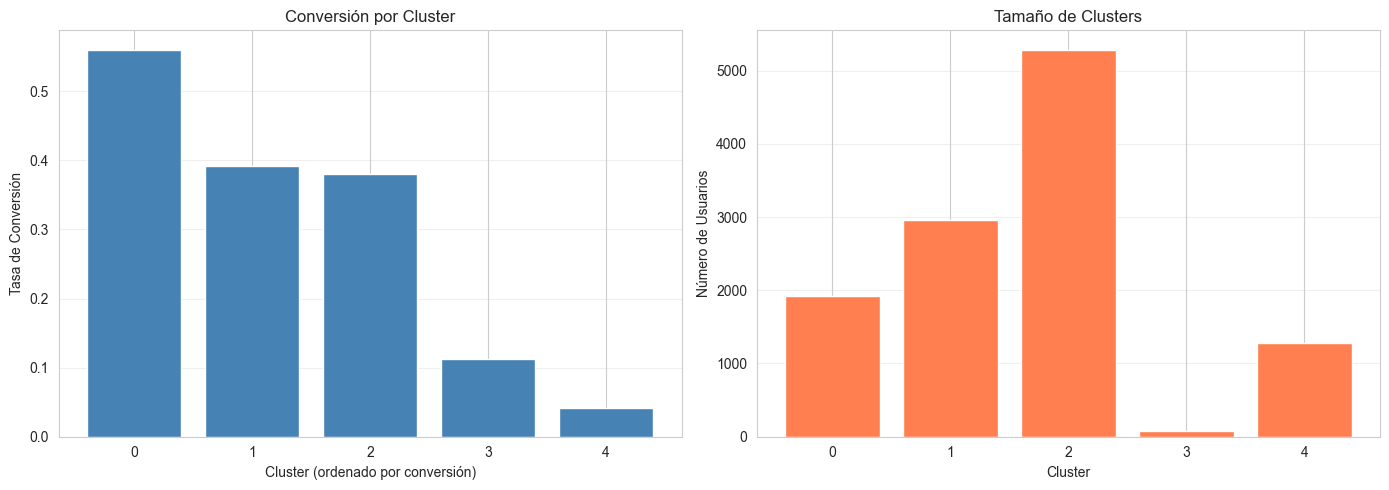

In [59]:
# ============================================================================
# CLUSTERING + NAIVE BAYES PIPELINE
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración: Cambiar a True para usar Spectral Clustering
USE_SPECTRAL = False  # Cambiar a True si KMeans no funciona bien

# ============================================================================
# PASO 0: VERIFICAR DATOS Y TARGET
# ============================================================================

print("=" * 60)
print("PASO 0: VERIFICACIÓN DE DATOS")
print("=" * 60)

# Verificar distribución del target
print(f"📊 Distribución Purchase en train:")
print(train_featured['Purchase'].value_counts())
print(f"\nProporción: {train_featured['Purchase'].value_counts(normalize=True)}")

# Detectar si Purchase ya es numérico o texto
purchase_type = train_featured['Purchase'].dtype
purchase_unique = train_featured['Purchase'].unique()
print(f"📋 Tipo de Purchase: {purchase_type}")
print(f"📋 Valores únicos: {purchase_unique}")

# Crear versión binaria consistente - ROBUSTO
if purchase_type in ['int64', 'float64', 'int32']:
    # Ya es numérico
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    print("   → Purchase ya es numérico (0/1)")
elif set(purchase_unique) <= {'0', '1', 0, 1}:
    # Es '0'/'1' como string
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    print("   → Purchase convertido de string '0'/'1' a numérico")
elif set(purchase_unique) <= {'Yes', 'No'}:
    # Es texto Yes/No
    train_featured['Purchase_Binary'] = (train_featured['Purchase'] == 'Yes').astype(int)
    print("   → Purchase convertido de 'Yes'/'No' a binario")
else:
    raise ValueError(f"❌ Valores inesperados en Purchase: {purchase_unique}")

print(f"✅ Purchase_Binary creado - Conversión: {train_featured['Purchase_Binary'].mean():.2%}")

# Verificar que no sea todo NaN
if train_featured['Purchase'].isnull().all():
    raise ValueError("❌ ERROR: Purchase es todo NaN en train!")

# ============================================================================
# PASO 1: PREPARAR DATOS PARA CLUSTERING
# ============================================================================

print("\n" + "=" * 60)
print("PASO 1: CLUSTERING PARA SEGMENTACIÓN")
print("=" * 60)

# Seleccionar features numéricas relevantes para clustering
clustering_features = [
    'Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart',
    'Email_Interaction', 'Socioeconomic_Status_Score', 'Engagement_Score',
    'Effective_Discount', 'Net_Price', 'Email_x_Engagement', 'Cart_x_Engagement',
    'Day_to_Campaign'
]

# Verificar que existan en el dataset
clustering_features = [f for f in clustering_features if f in train_featured.columns]
print(f"📊 Features para clustering: {len(clustering_features)}")

# Preparar datos
X_cluster_train = train_featured[clustering_features].copy()
X_cluster_val = val_featured[clustering_features].copy()
X_cluster_test = test_featured[clustering_features].copy()

# Verificar y reportar NaNs detalladamente
print(f"  NaNs en train: {X_cluster_train.isnull().sum().sum()}")
print(f"  NaNs en val: {X_cluster_val.isnull().sum().sum()}")
print(f"  NaNs en test: {X_cluster_test.isnull().sum().sum()}")

if X_cluster_test.isnull().any().any():
    print("\n⚠️  Columnas con NaNs en test:")
    nan_cols = X_cluster_test.isnull().sum()
    print(nan_cols[nan_cols > 0])

# SOLUCIÓN ROBUSTA: Imputar TODOS los NaNs con mediana de train
print("\n🔧 Imputando NaNs con mediana de train...")
for col in clustering_features:
    # Calcular mediana en train (incluso si no tiene NaNs)
    median_val = X_cluster_train[col].median()
    
    # Si la mediana es NaN, usar 0
    if pd.isna(median_val):
        median_val = 0
    
    # Aplicar a todos los datasets
    X_cluster_train[col].fillna(median_val, inplace=True)
    X_cluster_val[col].fillna(median_val, inplace=True)
    X_cluster_test[col].fillna(median_val, inplace=True)

# Verificación final
assert X_cluster_train.isnull().sum().sum() == 0, "❌ Train aún tiene NaNs"
assert X_cluster_val.isnull().sum().sum() == 0, "❌ Val aún tiene NaNs"
assert X_cluster_test.isnull().sum().sum() == 0, "❌ Test aún tiene NaNs"
print("✅ Todos los NaNs eliminados")

# Escalar (importante para K-Means)
scaler = StandardScaler()
X_cluster_train_scaled = scaler.fit_transform(X_cluster_train)
X_cluster_val_scaled = scaler.transform(X_cluster_val)
X_cluster_test_scaled = scaler.transform(X_cluster_test)

# ============================================================================
# PASO 2: ENCONTRAR NÚMERO ÓPTIMO DE CLUSTERS
# ============================================================================

print("\n🔍 Buscando número óptimo de clusters...")

# Probar diferentes números de clusters
cluster_range = range(2, 11)
results = []

for n_clusters in cluster_range:
    if USE_SPECTRAL:
        # Spectral Clustering (más lento pero puede capturar patrones no-convexos)
        clusterer = SpectralClustering(
            n_clusters=n_clusters, 
            random_state=42,
            affinity='nearest_neighbors',
            n_neighbors=10
        )
        clusters_train = clusterer.fit_predict(X_cluster_train_scaled)
        inertia = None  # Spectral no tiene inertia
    else:
        # K-Means (más rápido)
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters_train = clusterer.fit_predict(X_cluster_train_scaled)
        inertia = clusterer.inertia_
    
    # Calcular conversión por cluster
    train_with_clusters = train_featured.copy()
    train_with_clusters['Cluster'] = clusters_train
    
    # IMPORTANTE: Usar Purchase_Binary que ya creamos
    # Calcular métricas
    cluster_conversion = train_with_clusters.groupby('Cluster').agg({
        'Purchase_Binary': 'mean',  # Ya es 0/1
        'id': 'count'
    }).rename(columns={'id': 'count', 'Purchase_Binary': 'Purchase'})
    
    # Varianza de conversión entre clusters (queremos alta varianza)
    conversion_variance = cluster_conversion['Purchase'].var()
    
    # Rango de conversión (max - min)
    conversion_range = cluster_conversion['Purchase'].max() - cluster_conversion['Purchase'].min()
    
    results.append({
        'n_clusters': n_clusters,
        'conversion_variance': conversion_variance,
        'conversion_range': conversion_range,
        'inertia': inertia
    })
    
    print(f"  K={n_clusters}: varianza={conversion_variance:.4f}, rango={conversion_range:.4f}")

# Seleccionar el mejor (máxima varianza de conversión)
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['conversion_variance'].idxmax(), 'n_clusters']
print(f"\n✅ Mejor número de clusters: {int(best_k)} (maximiza diferenciación de conversión)")

# ============================================================================
# PASO 3: APLICAR CLUSTERING ÓPTIMO
# ============================================================================

print("\n" + "=" * 60)
print(f"PASO 2: APLICANDO {'SPECTRAL CLUSTERING' if USE_SPECTRAL else 'K-MEANS'} CON K={int(best_k)}")
print("=" * 60)

if USE_SPECTRAL:
    clusterer_final = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    )
    train_featured['Cluster'] = clusterer_final.fit_predict(X_cluster_train_scaled)
    
    # Para Spectral, necesitamos re-entrenar en val y test
    val_featured['Cluster'] = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    ).fit_predict(X_cluster_val_scaled)
    
    test_featured['Cluster'] = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    ).fit_predict(X_cluster_test_scaled)
else:
    kmeans_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
    train_featured['Cluster'] = kmeans_final.fit_predict(X_cluster_train_scaled)
    val_featured['Cluster'] = kmeans_final.predict(X_cluster_val_scaled)
    test_featured['Cluster'] = kmeans_final.predict(X_cluster_test_scaled)

# Analizar clusters
print("\n📊 ANÁLISIS DE CLUSTERS:")
cluster_analysis = train_featured.groupby('Cluster').agg({
    'Purchase_Binary': 'mean',  # Ya es 0/1
    'id': 'count',
    'Engagement_Score': 'mean',
    'Items_In_Cart': 'mean',
    'Net_Price': 'mean'
}).round(3)

cluster_analysis.columns = ['Conversion_Rate', 'Count', 'Avg_Engagement', 'Avg_Cart_Items', 'Avg_Net_Price']
cluster_analysis = cluster_analysis.sort_values('Conversion_Rate', ascending=False)
print(cluster_analysis)

# ============================================================================
# PASO 4: PREPARAR DATOS PARA NAIVE BAYES
# ============================================================================

print("\n" + "=" * 60)
print("PASO 3: NAIVE BAYES CON CLUSTERS COMO FEATURE")
print("=" * 60)

# CRÍTICO: Re-crear Purchase_Binary para validation (puede estar corrupto)
print("\n🔧 Creando Purchase_Binary para validation...")
if val_featured['Purchase'].dtype in ['int64', 'float64', 'int32']:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
elif set(val_featured['Purchase'].unique()) <= {'0', '1', 0, 1}:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
elif set(val_featured['Purchase'].unique()) <= {'Yes', 'No'}:
    val_featured['Purchase_Binary'] = (val_featured['Purchase'] == 'Yes').astype(int)
else:
    # Fallback: intentar conversión directa
    val_featured['Purchase_Binary'] = pd.to_numeric(val_featured['Purchase'], errors='coerce').fillna(0).astype(int)

print(f"   Val Purchase original: {val_featured['Purchase'].value_counts().to_dict()}")
print(f"   Val Purchase_Binary: {val_featured['Purchase_Binary'].value_counts().to_dict()}")
print(f"✅ Val Purchase_Binary - Conversión: {val_featured['Purchase_Binary'].mean():.2%}")

# Seleccionar features para Naive Bayes (incluir Cluster)
nb_features = clustering_features + ['Cluster', 'HighValue_Category', 'Email_Device_High']
nb_features = [f for f in nb_features if f in train_featured.columns]

print(f"📊 Features para Naive Bayes: {len(nb_features)}")
print(f"   (incluye Cluster como feature adicional)")

X_train_nb = train_featured[nb_features].copy()
y_train_nb = train_featured['Purchase_Binary']

X_val_nb = val_featured[nb_features].copy()
y_val_nb = val_featured['Purchase_Binary']

X_test_nb = test_featured[nb_features].copy()

# CRÍTICO: Imputar NaNs en features de NB también
print("\n🔧 Verificando NaNs en features de Naive Bayes...")
print(f"  Train NaNs: {X_train_nb.isnull().sum().sum()}")
print(f"  Val NaNs:   {X_val_nb.isnull().sum().sum()}")
print(f"  Test NaNs:  {X_test_nb.isnull().sum().sum()}")

if X_test_nb.isnull().any().any():
    print("\n⚠️  Imputando NaNs en test para Naive Bayes...")
    for col in nb_features:
        if X_test_nb[col].isnull().any():
            median_val = X_train_nb[col].median()
            if pd.isna(median_val):
                median_val = 0
            X_train_nb[col].fillna(median_val, inplace=True)
            X_val_nb[col].fillna(median_val, inplace=True)
            X_test_nb[col].fillna(median_val, inplace=True)
            print(f"    - {col}: imputado con {median_val}")

# Verificación final
assert X_train_nb.isnull().sum().sum() == 0, "❌ X_train_nb tiene NaNs"
assert X_val_nb.isnull().sum().sum() == 0, "❌ X_val_nb tiene NaNs"
assert X_test_nb.isnull().sum().sum() == 0, "❌ X_test_nb tiene NaNs"
print("✅ Datos limpios para Naive Bayes")

# ============================================================================
# PASO 5: ENTRENAR NAIVE BAYES
# ============================================================================

print("\n🚀 Entrenando Gaussian Naive Bayes...")

nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_nb)

# Predecir en train y validation
y_pred_train = nb_model.predict(X_train_nb)
y_pred_val = nb_model.predict(X_val_nb)

# Métricas
f1_train = f1_score(y_train_nb, y_pred_train, zero_division=0)
f1_val = f1_score(y_val_nb, y_pred_val, zero_division=0)

print(f"\n📈 RESULTADOS:")
print(f"  F1 Score (Train): {f1_train:.4f}")
print(f"  F1 Score (Val):   {f1_val:.4f}")

# Verificar si hay predicciones variadas
print(f"\n🔍 Distribución de predicciones (Val):")
print(f"  Predijo 'No':  {(y_pred_val == 0).sum()} ({(y_pred_val == 0).mean():.1%})")
print(f"  Predijo 'Yes': {(y_pred_val == 1).sum()} ({(y_pred_val == 1).mean():.1%})")

# Solo mostrar classification report si hay ambas clases
if len(np.unique(y_pred_val)) > 1:
    print("\n📊 Classification Report (Validation):")
    print(classification_report(y_val_nb, y_pred_val, target_names=['No', 'Yes'], zero_division=0))
else:
    print("\n⚠️  Modelo predice solo una clase - necesita ajuste")

# ============================================================================
# PASO 6: PREDECIR EN TEST Y GENERAR SUBMISSION
# ============================================================================

print("\n" + "=" * 60)
print("PASO 4: GENERANDO SUBMISSION FILE")
print("=" * 60)

# Predecir en test
y_pred_test = nb_model.predict(X_test_nb)

# Convertir a 'Yes'/'No'
y_pred_test_labels = ['Yes' if pred == 1 else 'No' for pred in y_pred_test]

# Crear submission
submission = pd.DataFrame({
    "id": test_featured["id"],
    "Purchase": y_pred_test_labels
})

# Guardar
#submission.to_csv("../data/submissions/clustering_nb_submission.csv", index=False)
print(f"✅ Submission guardado: ../data/submissions/clustering_nb_submission.csv")
print(f"   {len(submission)} predicciones")
print(f"   Conversión predicha: {(submission['Purchase'] == 'Yes').mean():.2%}")

# ============================================================================
# VISUALIZACIONES OPCIONALES
# ============================================================================

print("\n" + "=" * 60)
print("VISUALIZACIONES")
print("=" * 60)

# 1. Conversión por cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Conversión por cluster
cluster_conv = cluster_analysis['Conversion_Rate'].sort_values(ascending=False)
axes[0].bar(range(len(cluster_conv)), cluster_conv.values, color='steelblue')
axes[0].set_xlabel('Cluster (ordenado por conversión)')
axes[0].set_ylabel('Tasa de Conversión')
axes[0].set_title('Conversión por Cluster')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Distribución de tamaños
cluster_sizes = cluster_analysis['Count']
axes[1].bar(range(len(cluster_sizes)), cluster_sizes.values, color='coral')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Número de Usuarios')
axes[1].set_title('Tamaño de Clusters')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
#plt.savefig('../reports/figures/clustering_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Gráficos guardados: ../reports/figures/clustering_analysis.png")

print("\n" + "=" * 60)
print("✨ PIPELINE COMPLETADO")
print("=" * 60)

PASO 0: VERIFICACIÓN DE DATOS
📊 Distribución Purchase en train:
Purchase
0    7216
1    4305
Name: count, dtype: int64

Proporción: Purchase
0    0.626335
1    0.373665
Name: proportion, dtype: float64
📋 Tipo de Purchase: object
📋 Valores únicos: [0 1]
   → Purchase convertido de string '0'/'1' a numérico
✅ Purchase_Binary creado - Conversión: 37.37%

PASO 1: CLUSTERING PARA SEGMENTACIÓN
📊 Features para clustering: 13
  NaNs en train: 0
  NaNs en val: 0
  NaNs en test: 400

⚠️  Columnas con NaNs en test:
Day_to_Campaign    400
dtype: int64

🔧 Imputando NaNs con mediana de train...
✅ Todos los NaNs eliminados

🔍 Buscando configuración óptima...
📊 Comparando K-Means vs Spectral Clustering...


ALGORITMO: KMEANS
  K=2: varianza=0.0350, rango=0.2644
  K=3: varianza=0.0273, rango=0.3255
  K=4: varianza=0.0406, rango=0.4206
  K=5: varianza=0.0462, rango=0.5187
  K=6: varianza=0.0409, rango=0.5531
  K=7: varianza=0.0368, rango=0.5760
  K=8: varianza=0.0326, rango=0.5849
  K=9: varianza=0.0336

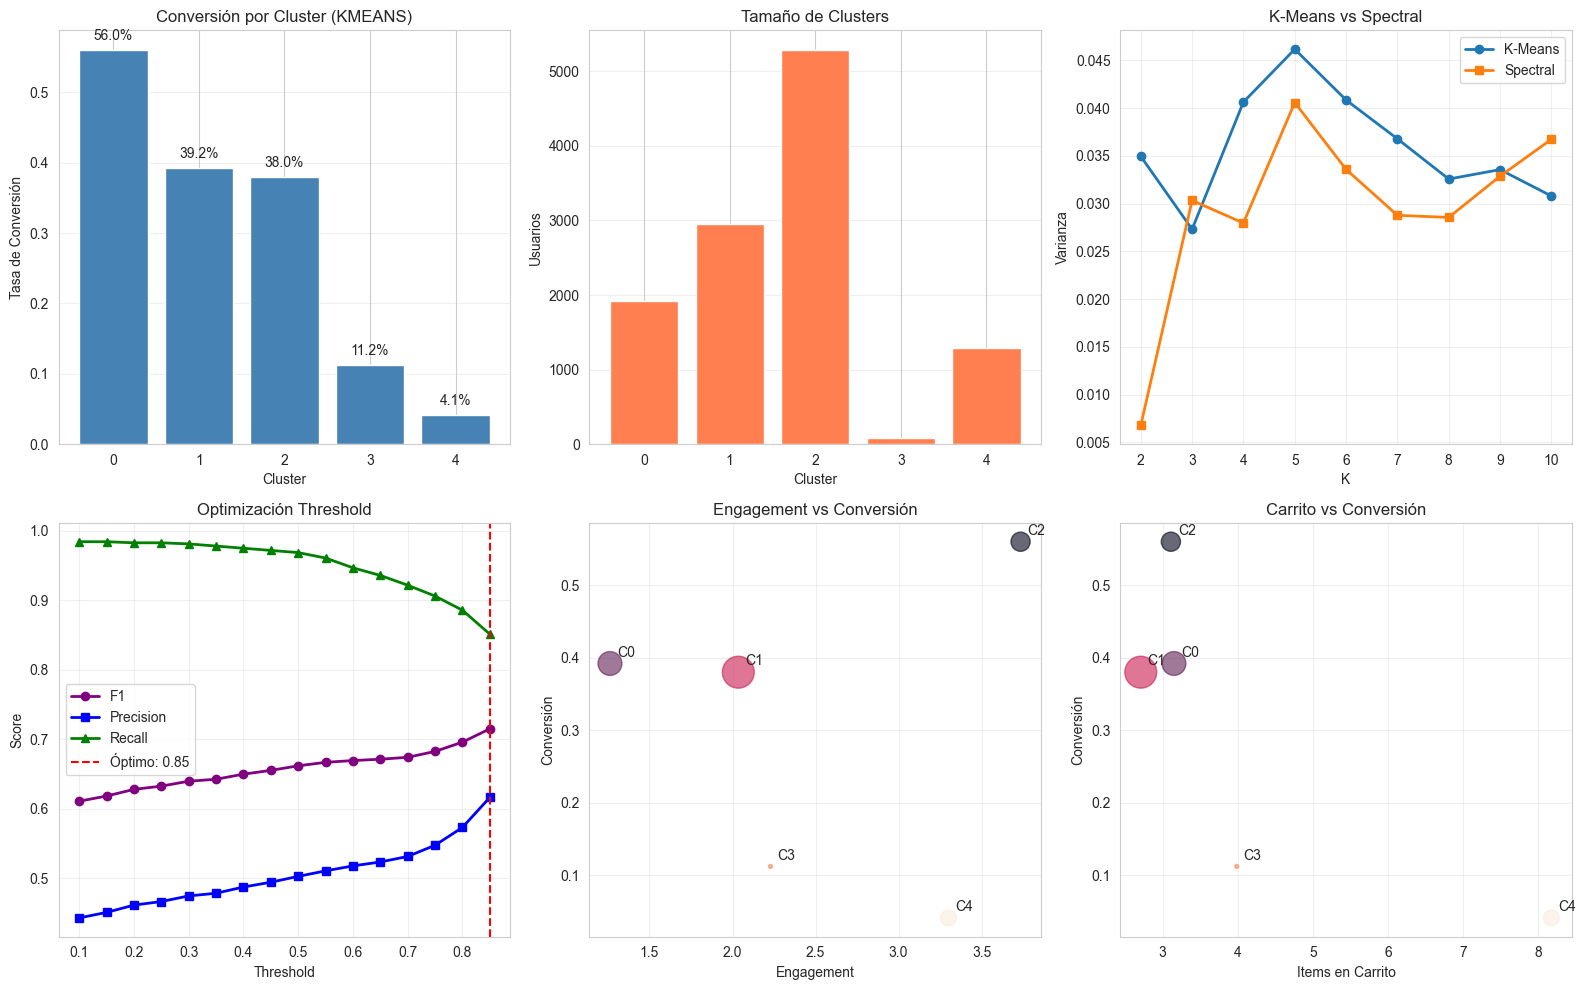

In [61]:
# ============================================================================
# CLUSTERING + NAIVE BAYES PIPELINE COMPLETO
# Incluye: Comparación K-Means vs Spectral + Optimización de Threshold
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURACIÓN
# ============================================================================
COMPARE_ALGORITHMS = True   # True = compara K-Means vs Spectral
OPTIMIZE_THRESHOLD = True   # True = encuentra el mejor threshold

# ============================================================================
# PASO 0: VERIFICAR DATOS Y TARGET
# ============================================================================

print("=" * 60)
print("PASO 0: VERIFICACIÓN DE DATOS")
print("=" * 60)

# Verificar distribución del target
print(f"📊 Distribución Purchase en train:")
print(train_featured['Purchase'].value_counts())
print(f"\nProporción: {train_featured['Purchase'].value_counts(normalize=True)}")

# Detectar tipo y crear Purchase_Binary
purchase_type = train_featured['Purchase'].dtype
purchase_unique = train_featured['Purchase'].unique()
print(f"📋 Tipo de Purchase: {purchase_type}")
print(f"📋 Valores únicos: {purchase_unique}")

if purchase_type in ['int64', 'float64', 'int32']:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    print("   → Purchase ya es numérico (0/1)")
elif set(purchase_unique) <= {'0', '1', 0, 1}:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    print("   → Purchase convertido de string '0'/'1' a numérico")
elif set(purchase_unique) <= {'Yes', 'No'}:
    train_featured['Purchase_Binary'] = (train_featured['Purchase'] == 'Yes').astype(int)
    print("   → Purchase convertido de 'Yes'/'No' a binario")
else:
    raise ValueError(f"❌ Valores inesperados en Purchase: {purchase_unique}")

print(f"✅ Purchase_Binary creado - Conversión: {train_featured['Purchase_Binary'].mean():.2%}")

# ============================================================================
# PASO 1: PREPARAR DATOS PARA CLUSTERING
# ============================================================================

print("\n" + "=" * 60)
print("PASO 1: CLUSTERING PARA SEGMENTACIÓN")
print("=" * 60)

# Features para clustering
clustering_features = [
    'Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart',
    'Email_Interaction', 'Socioeconomic_Status_Score', 'Engagement_Score',
    'Effective_Discount', 'Net_Price', 'Email_x_Engagement', 'Cart_x_Engagement',
    'Day_to_Campaign'
]

clustering_features = [f for f in clustering_features if f in train_featured.columns]
print(f"📊 Features para clustering: {len(clustering_features)}")

# Preparar datos
X_cluster_train = train_featured[clustering_features].copy()
X_cluster_val = val_featured[clustering_features].copy()
X_cluster_test = test_featured[clustering_features].copy()

# Verificar NaNs
print(f"  NaNs en train: {X_cluster_train.isnull().sum().sum()}")
print(f"  NaNs en val: {X_cluster_val.isnull().sum().sum()}")
print(f"  NaNs en test: {X_cluster_test.isnull().sum().sum()}")

if X_cluster_test.isnull().any().any():
    print("\n⚠️  Columnas con NaNs en test:")
    nan_cols = X_cluster_test.isnull().sum()
    print(nan_cols[nan_cols > 0])

# Imputar NaNs
print("\n🔧 Imputando NaNs con mediana de train...")
for col in clustering_features:
    median_val = X_cluster_train[col].median()
    if pd.isna(median_val):
        median_val = 0
    X_cluster_train[col].fillna(median_val, inplace=True)
    X_cluster_val[col].fillna(median_val, inplace=True)
    X_cluster_test[col].fillna(median_val, inplace=True)

assert X_cluster_train.isnull().sum().sum() == 0
assert X_cluster_val.isnull().sum().sum() == 0
assert X_cluster_test.isnull().sum().sum() == 0
print("✅ Todos los NaNs eliminados")

# Escalar
scaler = StandardScaler()
X_cluster_train_scaled = scaler.fit_transform(X_cluster_train)
X_cluster_val_scaled = scaler.transform(X_cluster_val)
X_cluster_test_scaled = scaler.transform(X_cluster_test)

# ============================================================================
# PASO 2: COMPARAR ALGORITMOS Y ENCONTRAR ÓPTIMO
# ============================================================================

print("\n🔍 Buscando configuración óptima...")

if COMPARE_ALGORITHMS:
    print("📊 Comparando K-Means vs Spectral Clustering...\n")

algorithms_results = {'kmeans': [], 'spectral': []}
cluster_range = range(2, 11)

for algo_name in (['kmeans', 'spectral'] if COMPARE_ALGORITHMS else ['kmeans']):
    print(f"\n{'='*60}")
    print(f"ALGORITMO: {algo_name.upper()}")
    print('='*60)
    
    for n_clusters in cluster_range:
        if algo_name == 'spectral':
            clusterer = SpectralClustering(
                n_clusters=n_clusters, 
                random_state=42,
                affinity='nearest_neighbors',
                n_neighbors=10
            )
            clusters_train = clusterer.fit_predict(X_cluster_train_scaled)
            inertia = None
        else:
            clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            clusters_train = clusterer.fit_predict(X_cluster_train_scaled)
            inertia = clusterer.inertia_
        
        # Calcular conversión por cluster
        train_with_clusters = train_featured.copy()
        train_with_clusters['Cluster'] = clusters_train
        
        cluster_conversion = train_with_clusters.groupby('Cluster').agg({
            'Purchase_Binary': 'mean',
            'id': 'count'
        }).rename(columns={'id': 'count', 'Purchase_Binary': 'Purchase'})
        
        conversion_variance = cluster_conversion['Purchase'].var()
        conversion_range = cluster_conversion['Purchase'].max() - cluster_conversion['Purchase'].min()
        
        algorithms_results[algo_name].append({
            'n_clusters': n_clusters,
            'conversion_variance': conversion_variance,
            'conversion_range': conversion_range,
            'inertia': inertia,
            'clusterer': clusterer
        })
        
        print(f"  K={n_clusters}: varianza={conversion_variance:.4f}, rango={conversion_range:.4f}")

# Seleccionar mejor algoritmo y K
print("\n" + "="*60)
print("COMPARACIÓN Y SELECCIÓN")
print("="*60)

best_algo = 'kmeans'
best_k = 5

if COMPARE_ALGORITHMS:
    kmeans_avg_var = np.mean([r['conversion_variance'] for r in algorithms_results['kmeans']])
    spectral_avg_var = np.mean([r['conversion_variance'] for r in algorithms_results['spectral']])
    
    print(f"📊 Varianza promedio K-Means:   {kmeans_avg_var:.4f}")
    print(f"📊 Varianza promedio Spectral:  {spectral_avg_var:.4f}")
    
    best_algo = 'spectral' if spectral_avg_var > kmeans_avg_var else 'kmeans'
    print(f"\n✅ Mejor algoritmo: {best_algo.upper()}")

results_df = pd.DataFrame(algorithms_results[best_algo])
best_k = results_df.loc[results_df['conversion_variance'].idxmax(), 'n_clusters']
print(f"✅ Mejor K: {int(best_k)} (maximiza varianza de conversión)")

# ============================================================================
# PASO 3: APLICAR CLUSTERING ÓPTIMO
# ============================================================================

print("\n" + "=" * 60)
print(f"PASO 2: APLICANDO {best_algo.upper()} CON K={int(best_k)}")
print("=" * 60)

if best_algo == 'spectral':
    clusterer_final = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    )
    train_featured['Cluster'] = clusterer_final.fit_predict(X_cluster_train_scaled)
    
    val_featured['Cluster'] = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    ).fit_predict(X_cluster_val_scaled)
    
    test_featured['Cluster'] = SpectralClustering(
        n_clusters=int(best_k), 
        random_state=42,
        affinity='nearest_neighbors',
        n_neighbors=10
    ).fit_predict(X_cluster_test_scaled)
else:
    kmeans_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
    train_featured['Cluster'] = kmeans_final.fit_predict(X_cluster_train_scaled)
    val_featured['Cluster'] = kmeans_final.predict(X_cluster_val_scaled)
    test_featured['Cluster'] = kmeans_final.predict(X_cluster_test_scaled)

# Analizar clusters
print("\n📊 ANÁLISIS DE CLUSTERS:")
cluster_analysis = train_featured.groupby('Cluster').agg({
    'Purchase_Binary': 'mean',
    'id': 'count',
    'Engagement_Score': 'mean',
    'Items_In_Cart': 'mean',
    'Net_Price': 'mean'
}).round(3)

cluster_analysis.columns = ['Conversion_Rate', 'Count', 'Avg_Engagement', 'Avg_Cart_Items', 'Avg_Net_Price']
cluster_analysis = cluster_analysis.sort_values('Conversion_Rate', ascending=False)
print(cluster_analysis)

# ============================================================================
# PASO 4: PREPARAR DATOS PARA NAIVE BAYES
# ============================================================================

print("\n" + "=" * 60)
print("PASO 3: NAIVE BAYES CON CLUSTERS")
print("=" * 60)

# Crear Purchase_Binary para validation
print("\n🔧 Creando Purchase_Binary para validation...")
if val_featured['Purchase'].dtype in ['int64', 'float64', 'int32']:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
elif set(val_featured['Purchase'].unique()) <= {'0', '1', 0, 1}:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
elif set(val_featured['Purchase'].unique()) <= {'Yes', 'No'}:
    val_featured['Purchase_Binary'] = (val_featured['Purchase'] == 'Yes').astype(int)
else:
    val_featured['Purchase_Binary'] = pd.to_numeric(val_featured['Purchase'], errors='coerce').fillna(0).astype(int)

print(f"   Val Purchase original: {val_featured['Purchase'].value_counts().to_dict()}")
print(f"   Val Purchase_Binary: {val_featured['Purchase_Binary'].value_counts().to_dict()}")
print(f"✅ Val Purchase_Binary - Conversión: {val_featured['Purchase_Binary'].mean():.2%}")

# Features para NB
nb_features = clustering_features + ['Cluster', 'HighValue_Category', 'Email_Device_High']
nb_features = [f for f in nb_features if f in train_featured.columns]

print(f"📊 Features para Naive Bayes: {len(nb_features)}")

X_train_nb = train_featured[nb_features].copy()
y_train_nb = train_featured['Purchase_Binary']

X_val_nb = val_featured[nb_features].copy()
y_val_nb = val_featured['Purchase_Binary']

X_test_nb = test_featured[nb_features].copy()

# Imputar NaNs en features de NB
print("\n🔧 Verificando NaNs en features de Naive Bayes...")
print(f"  Train NaNs: {X_train_nb.isnull().sum().sum()}")
print(f"  Val NaNs:   {X_val_nb.isnull().sum().sum()}")
print(f"  Test NaNs:  {X_test_nb.isnull().sum().sum()}")

if X_test_nb.isnull().any().any():
    print("\n⚠️  Imputando NaNs en test para Naive Bayes...")
    for col in nb_features:
        if X_test_nb[col].isnull().any():
            median_val = X_train_nb[col].median()
            if pd.isna(median_val):
                median_val = 0
            X_train_nb[col].fillna(median_val, inplace=True)
            X_val_nb[col].fillna(median_val, inplace=True)
            X_test_nb[col].fillna(median_val, inplace=True)
            print(f"    - {col}: imputado con {median_val}")

assert X_train_nb.isnull().sum().sum() == 0
assert X_val_nb.isnull().sum().sum() == 0
assert X_test_nb.isnull().sum().sum() == 0
print("✅ Datos limpios para Naive Bayes")

# ============================================================================
# PASO 5: ENTRENAR NAIVE BAYES Y OPTIMIZAR THRESHOLD
# ============================================================================

print("\n🚀 Entrenando Gaussian Naive Bayes...")

nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_nb)

# Predecir probabilidades
y_pred_proba_train = nb_model.predict_proba(X_train_nb)[:, 1]
y_pred_proba_val = nb_model.predict_proba(X_val_nb)[:, 1]

# Predicción con threshold 0.5
y_pred_train = (y_pred_proba_train >= 0.5).astype(int)
y_pred_val = (y_pred_proba_val >= 0.5).astype(int)

f1_train_default = f1_score(y_train_nb, y_pred_train, zero_division=0)
f1_val_default = f1_score(y_val_nb, y_pred_val, zero_division=0)

print(f"\n📈 RESULTADOS CON THRESHOLD 0.5:")
print(f"  F1 Score (Train): {f1_train_default:.4f}")
print(f"  F1 Score (Val):   {f1_val_default:.4f}")

# Optimización de threshold
if OPTIMIZE_THRESHOLD:
    print("\n" + "="*60)
    print("OPTIMIZACIÓN DE THRESHOLD")
    print("="*60)
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    threshold_results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba_val >= thresh).astype(int)
        f1 = f1_score(y_val_nb, y_pred_thresh, zero_division=0)
        precision = precision_score(y_val_nb, y_pred_thresh, zero_division=0)
        recall = recall_score(y_val_nb, y_pred_thresh, zero_division=0)
        
        threshold_results.append({
            'threshold': thresh,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    best_threshold_idx = threshold_df['f1'].idxmax()
    best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']
    best_f1 = threshold_df.loc[best_threshold_idx, 'f1']
    
    print(f"\n✅ THRESHOLD ÓPTIMO: {best_threshold:.2f}")
    print(f"   F1 Score: {best_f1:.4f}")
    print(f"   Precision: {threshold_df.loc[best_threshold_idx, 'precision']:.4f}")
    print(f"   Recall: {threshold_df.loc[best_threshold_idx, 'recall']:.4f}")
    print(f"\n   Mejora vs threshold 0.5: +{(best_f1 - f1_val_default)*100:.2f}%")
    
    y_pred_val = (y_pred_proba_val >= best_threshold).astype(int)
    final_threshold = best_threshold
else:
    final_threshold = 0.5
    threshold_df = None

print(f"\n🔍 Distribución de predicciones (Val):")
print(f"  Predijo 'No':  {(y_pred_val == 0).sum()} ({(y_pred_val == 0).mean():.1%})")
print(f"  Predijo 'Yes': {(y_pred_val == 1).sum()} ({(y_pred_val == 1).mean():.1%})")

if len(np.unique(y_pred_val)) > 1:
    print("\n📊 Classification Report (Validation):")
    print(classification_report(y_val_nb, y_pred_val, target_names=['No', 'Yes'], zero_division=0))

# ============================================================================
# PASO 6: PREDECIR EN TEST Y GENERAR SUBMISSION
# ============================================================================

print("\n" + "=" * 60)
print("PASO 4: GENERANDO SUBMISSION")
print("=" * 60)

y_pred_proba_test = nb_model.predict_proba(X_test_nb)[:, 1]
y_pred_test = (y_pred_proba_test >= final_threshold).astype(int)
y_pred_test_labels = ['Yes' if pred == 1 else 'No' for pred in y_pred_test]

submission = pd.DataFrame({
    "id": test_featured["id"],
    "Purchase": y_pred_test_labels
})

filename = f"../data/submissions/clustering_nb_{best_algo}_submission.csv"
#submission.to_csv(filename, index=False)
print(f"✅ Submission guardado: {filename}")
print(f"   {len(submission)} predicciones")
print(f"   Conversión predicha: {(submission['Purchase'] == 'Yes').mean():.2%}")
print(f"   Algoritmo: {best_algo.upper()}, K={int(best_k)}, Threshold={final_threshold:.2f}")

# ============================================================================
# VISUALIZACIONES
# ============================================================================

print("\n" + "=" * 60)
print("GENERANDO VISUALIZACIONES")
print("=" * 60)

fig = plt.figure(figsize=(16, 10))

# 1. Conversión por cluster
ax1 = plt.subplot(2, 3, 1)
cluster_conv = cluster_analysis['Conversion_Rate'].sort_values(ascending=False)
bars = ax1.bar(range(len(cluster_conv)), cluster_conv.values, color='steelblue')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Tasa de Conversión')
ax1.set_title(f'Conversión por Cluster ({best_algo.upper()})')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, cluster_conv.values)):
    ax1.text(i, val + 0.01, f'{val:.1%}', ha='center', va='bottom')

# 2. Tamaño de clusters
ax2 = plt.subplot(2, 3, 2)
cluster_sizes = cluster_analysis['Count']
ax2.bar(range(len(cluster_sizes)), cluster_sizes.values, color='coral')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Usuarios')
ax2.set_title('Tamaño de Clusters')
ax2.grid(axis='y', alpha=0.3)

# 3. Comparación algoritmos
if COMPARE_ALGORITHMS:
    ax3 = plt.subplot(2, 3, 3)
    comparison_data = []
    for k in cluster_range:
        kmeans_var = [r for r in algorithms_results['kmeans'] if r['n_clusters'] == k][0]['conversion_variance']
        spectral_var = [r for r in algorithms_results['spectral'] if r['n_clusters'] == k][0]['conversion_variance']
        comparison_data.append({'k': k, 'kmeans': kmeans_var, 'spectral': spectral_var})
    
    comp_df = pd.DataFrame(comparison_data)
    ax3.plot(comp_df['k'], comp_df['kmeans'], 'o-', label='K-Means', linewidth=2)
    ax3.plot(comp_df['k'], comp_df['spectral'], 's-', label='Spectral', linewidth=2)
    ax3.set_xlabel('K')
    ax3.set_ylabel('Varianza')
    ax3.set_title('K-Means vs Spectral')
    ax3.legend()
    ax3.grid(alpha=0.3)

# 4. Threshold optimization
if OPTIMIZE_THRESHOLD and threshold_df is not None:
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(threshold_df['threshold'], threshold_df['f1'], 'o-', label='F1', linewidth=2, color='purple')
    ax4.plot(threshold_df['threshold'], threshold_df['precision'], 's-', label='Precision', linewidth=2, color='blue')
    ax4.plot(threshold_df['threshold'], threshold_df['recall'], '^-', label='Recall', linewidth=2, color='green')
    ax4.axvline(best_threshold, color='red', linestyle='--', label=f'Óptimo: {best_threshold:.2f}')
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Score')
    ax4.set_title('Optimización Threshold')
    ax4.legend()
    ax4.grid(alpha=0.3)

# 5. Engagement vs Conversion
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(cluster_analysis['Avg_Engagement'], 
            cluster_analysis['Conversion_Rate'],
            s=cluster_analysis['Count']/10,
            alpha=0.6,
            c=range(len(cluster_analysis)))
ax5.set_xlabel('Engagement')
ax5.set_ylabel('Conversión')
ax5.set_title('Engagement vs Conversión')
ax5.grid(alpha=0.3)
for idx, row in cluster_analysis.iterrows():
    ax5.annotate(f'C{idx}', 
                (row['Avg_Engagement'], row['Conversion_Rate']),
                xytext=(5, 5), textcoords='offset points')

# 6. Cart vs Conversion
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(cluster_analysis['Avg_Cart_Items'], 
            cluster_analysis['Conversion_Rate'],
            s=cluster_analysis['Count']/10,
            alpha=0.6,
            c=range(len(cluster_analysis)))
ax6.set_xlabel('Items en Carrito')
ax6.set_ylabel('Conversión')
ax6.set_title('Carrito vs Conversión')
ax6.grid(alpha=0.3)
for idx, row in cluster_analysis.iterrows():
    ax6.annotate(f'C{idx}', 
                (row['Avg_Cart_Items'], row['Conversion_Rate']),
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
#plt.savefig('../reports/figures/clustering_analysis_complete.png', dpi=150, bbox_inches='tight')
print("✅ Gráficos guardados: ../reports/figures/clustering_analysis_complete.png")

print("\n" + "=" * 60)
print("✨ PIPELINE COMPLETADO")
print("=" * 60)

🚀 PIPELINE AVANZADO CON GRADIENT BOOSTING

📊 VERIFICANDO CLUSTERS...
Train tiene cluster: True
Distribución de clusters:
Cluster
0    2953
1    5284
2    1918
3      80
4    1286
Name: count, dtype: int64
⚡ Ejecutando Feature Engineering...
🔧 Creando features por cluster...
✅ Features creadas: 71 columnas totales
🔧 Creando features por cluster...
✅ Features creadas: 70 columnas totales
🔧 Creando features por cluster...
✅ Features creadas: 70 columnas totales

PREPARANDO DATOS PARA BOOSTING MODELS
📊 Features seleccionadas: 65
❌ Columnas excluidas o no coincidentes: set()
📂 Features categóricas detectadas: 8


[I 2025-11-29 11:18:46,014] A new study created in memory with name: no-name-6ca78b08-6349-44d7-b4d0-3b11f071aa1b


✅ Train shape: (11521, 65)
✅ Val shape: (1934, 65)
✅ Test shape: (6265, 65)

ENTRENANDO MODELOS (XGBOOST OPTIMIZADO + OTHERS)
📊 Scale pos weight base: 1.68

🤖 1. Optimizando XGBoost con Optuna...


[I 2025-11-29 11:18:48,503] Trial 0 finished with value: 0.7754237288135594 and parameters: {'n_estimators': 773, 'max_depth': 9, 'learning_rate': 0.022228613210180895, 'subsample': 0.723847783777291, 'colsample_bytree': 0.7937481930484369, 'scale_pos_weight': 3.932854184177125, 'gamma': 2.636564429602546, 'reg_alpha': 4.21941488196644, 'reg_lambda': 3.02183255593809}. Best is trial 0 with value: 0.7754237288135594.
[I 2025-11-29 11:18:49,665] Trial 1 finished with value: 0.7692307692307693 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 0.01088888817863136, 'subsample': 0.9746449410447057, 'colsample_bytree': 0.9318288156687458, 'scale_pos_weight': 2.9490253474954358, 'gamma': 3.385685794818203, 'reg_alpha': 2.8804904883186278, 'reg_lambda': 3.4685391923760482}. Best is trial 0 with value: 0.7754237288135594.
[I 2025-11-29 11:18:51,870] Trial 2 finished with value: 0.7771509167842031 and parameters: {'n_estimators': 418, 'max_depth': 9, 'learning_rate': 0.011301

   🎯 Mejor F1 encontrado: 0.7860
   🚀 Entrenando XGBoost Final...

🚀 2. LightGBM (Standard)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's auc: 0.926474

🚀 3. CatBoost (Standard)

✅ Paso 4 Completado: Modelos listos para Ensemble.

OPTIMIZACIÓN DE THRESHOLDS

XGBoost:
  Threshold óptimo: 0.60
  F1 Score: 0.7860
  AUC: 0.9283

LightGBM:
  Threshold óptimo: 0.50
  F1 Score: 0.7755
  AUC: 0.9265

CatBoost:
  Threshold óptimo: 0.50
  F1 Score: 0.7804
  AUC: 0.9301

📊 RANKING DE MODELOS:
   model  best_threshold  f1_score      auc
 XGBoost             0.6  0.786026 0.928336
CatBoost             0.5  0.780418 0.930095
LightGBM             0.5  0.775540 0.926474

🏆 MEJOR MODELO: XGBoost

ENSEMBLE DE MODELOS
Modelos en ensemble: ['XGBoost', 'CatBoost', 'LightGBM']
Pesos: {'XGBoost': np.float64(0.3356241647212146), 'CatBoost': np.float64(0.33322934226756035), 'LightGBM': np.float64(0.33114649301122495)}

✅ Ensemble F1: 0.7846
✅ Th

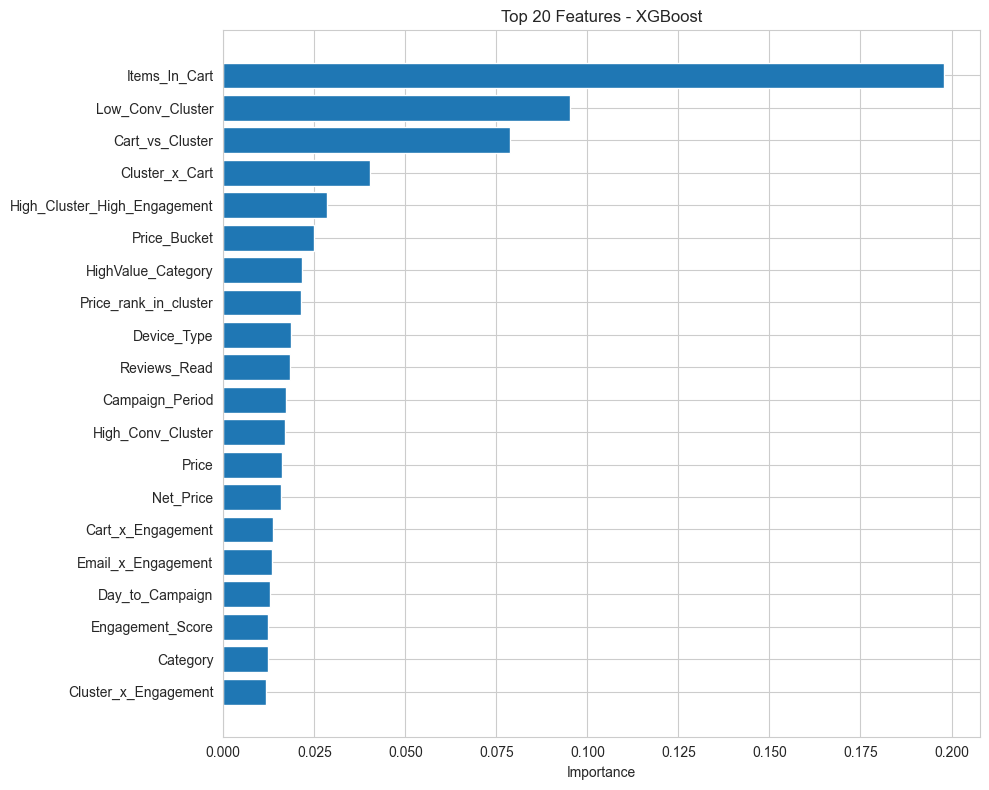

In [72]:
# ============================================================================
# ADVANCED BOOSTING PIPELINE
# Clustering + XGBoost/CatBoost/LightGBM con Feature Engineering Avanzado
# ============================================================================
import optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Boosting libraries
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  CatBoost no instalado. Instalarlo con: pip install catboost")
    CATBOOST_AVAILABLE = False

# ============================================================================
# CONFIGURACIÓN
# ============================================================================
OPTIMIZE_HYPERPARAMS = False  # True = busca mejores hiperparámetros (más lento)
USE_ENSEMBLE = True           # True = combina predicciones de mejores modelos

print("🚀 PIPELINE AVANZADO CON GRADIENT BOOSTING")
print("=" * 70)

# ============================================================================
# PASO 1: CLUSTERING (USAR RESULTADOS ANTERIORES)
# ============================================================================
# Nota: Asumimos que ya tienes train_featured, val_featured, test_featured
# con la columna 'Cluster' del pipeline anterior

print("\n📊 VERIFICANDO CLUSTERS...")
print(f"Train tiene cluster: {'Cluster' in train_featured.columns}")
print(f"Distribución de clusters:")
print(train_featured['Cluster'].value_counts().sort_index())

# Si no tienes clusters, ejecutar K-Means rápido
if 'Cluster' not in train_featured.columns:
    print("\n⚠️  Ejecutando clustering rápido...")
    
    clustering_features = [
        'Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart',
        'Email_Interaction', 'Socioeconomic_Status_Score', 'Engagement_Score',
        'Effective_Discount', 'Net_Price', 'Email_x_Engagement', 'Cart_x_Engagement',
        'Day_to_Campaign'
    ]
    clustering_features = [f for f in clustering_features if f in train_featured.columns]
    
    X_cluster = train_featured[clustering_features].fillna(train_featured[clustering_features].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    train_featured['Cluster'] = kmeans.fit_predict(X_scaled)
    
    X_val_cluster = val_featured[clustering_features].fillna(train_featured[clustering_features].median())
    val_featured['Cluster'] = kmeans.predict(scaler.transform(X_val_cluster))
    
    X_test_cluster = test_featured[clustering_features].fillna(train_featured[clustering_features].median())
    test_featured['Cluster'] = kmeans.predict(scaler.transform(X_test_cluster))

# ============================================================================
# CORRECCIÓN PASO 2: FEATURE ENGINEERING AVANZADO (ROBUSTO A NaNs)
# ============================================================================

# 1. PRIMERO: Asegurar que Purchase_Binary existe y manejar NaNs
# ----------------------------------------------------------------------------

# Para TRAIN: No debería haber NaNs en el target
if 'Purchase_Binary' not in train_featured.columns and 'Purchase' in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    print("✅ Purchase_Binary creado en Train")

# Para VAL: No debería haber NaNs
if 'Purchase_Binary' not in val_featured.columns and 'Purchase' in val_featured.columns:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)

# Para TEST: Aquí es donde fallaba.
# Si existe 'Purchase' pero está vacío (NaN), llenamos con 0 para evitar el error.
if 'Purchase_Binary' not in test_featured.columns:
    if 'Purchase' in test_featured.columns:
        # Llenamos NaNs con 0 antes de convertir a int
        test_featured['Purchase_Binary'] = test_featured['Purchase'].fillna(0).astype(int)
    else:
        # Si no existe la columna Purchase, creamos una dummy en 0
        test_featured['Purchase_Binary'] = 0

# 2. SEGUNDO: Función Corregida (Manejo de columnas duplicadas)
# ----------------------------------------------------------------------------
def advanced_cluster_features(df, cluster_stats=None, is_train=True):
    """
    Crea features avanzadas usando información de clusters.
    Maneja duplicados para permitir re-ejecución del notebook.
    """
    df = df.copy() 
    
    if is_train:
        # Calcular estadísticas por cluster en train
        cluster_stats = df.groupby('Cluster').agg({
            'Purchase_Binary': 'mean',
            'Engagement_Score': 'mean',
            'Items_In_Cart': 'mean',
            'Net_Price': 'mean',
            'Email_Interaction': 'mean'
        }).add_suffix('_cluster_mean')
    
    # --- FIX: LIMPIEZA DE COLUMNAS PREVIA ---
    # Identificar columnas que vamos a mergear
    new_cols = cluster_stats.columns.tolist()
    
    # Si las columnas ya existen en df (por correr la celda 2 veces), las borramos
    cols_to_drop = [c for c in new_cols if c in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
    # ----------------------------------------

    # Hacer merge de estadísticas
    df = df.merge(cluster_stats, left_on='Cluster', right_index=True, how='left')
    
    # Features derivadas de clusters
    print("🔧 Creando features por cluster...")
    
    # 1. Distancia al promedio del cluster
    df['Engagement_vs_Cluster'] = df['Engagement_Score'] - df['Engagement_Score_cluster_mean']
    df['Cart_vs_Cluster'] = df['Items_In_Cart'] - df['Items_In_Cart_cluster_mean']
    df['Price_vs_Cluster'] = df['Net_Price'] - df['Net_Price_cluster_mean']
    
    # 2. Flags de clusters high/low performance
    if is_train:
        high_conv_clusters = cluster_stats['Purchase_Binary_cluster_mean'].nlargest(2).index
        low_conv_clusters = cluster_stats['Purchase_Binary_cluster_mean'].nsmallest(2).index
    else:
        # Usar clusters guardados o definidos manualmente
        high_conv_clusters = cluster_stats['Purchase_Binary_cluster_mean'].nlargest(2).index if cluster_stats is not None else []
        low_conv_clusters = cluster_stats['Purchase_Binary_cluster_mean'].nsmallest(2).index if cluster_stats is not None else []
    
    df['High_Conv_Cluster'] = df['Cluster'].isin(high_conv_clusters).astype(int)
    df['Low_Conv_Cluster'] = df['Cluster'].isin(low_conv_clusters).astype(int)
    
    # 3. Interacciones cluster × otras features
    df['Cluster_x_Engagement'] = df['Cluster'] * df['Engagement_Score']
    df['Cluster_x_Cart'] = df['Cluster'] * df['Items_In_Cart']
    df['Cluster_x_Email'] = df['Cluster'] * df['Email_Interaction']
    
    # 4. Rank dentro del cluster
    df['Engagement_rank_in_cluster'] = df.groupby('Cluster')['Engagement_Score'].rank(pct=True)
    df['Price_rank_in_cluster'] = df.groupby('Cluster')['Net_Price'].rank(pct=True)
    
    # 5. Outlier detection por cluster
    eng_vs_cluster_90 = df.groupby('Cluster')['Engagement_vs_Cluster'].transform(lambda x: x.quantile(0.9))
    df['Is_High_Engagement_Outlier'] = (df['Engagement_vs_Cluster'] > eng_vs_cluster_90).astype(int)
    
    # 6. Cluster performance × user behavior
    df['High_Cluster_High_Engagement'] = (df['High_Conv_Cluster'] * df['Engagement_Score']).clip(0, 5)
    
    if 'Purchase_Binary_cluster_mean' in df.columns:
        df['Cluster_Conv_x_Email'] = df['Purchase_Binary_cluster_mean'] * df['Email_Interaction']
    
    print(f"✅ Features creadas: {df.shape[1]} columnas totales")
    
    if is_train:
        return df, cluster_stats
    else:
        return df

# Aplicar feature engineering
print("⚡ Ejecutando Feature Engineering...")
train_featured, cluster_stats = advanced_cluster_features(train_featured, is_train=True)
val_featured = advanced_cluster_features(val_featured, cluster_stats=cluster_stats, is_train=False)
test_featured = advanced_cluster_features(test_featured, cluster_stats=cluster_stats, is_train=False)

# ============================================================================
# PASO 3: PREPARAR DATOS PARA MODELOS (CORREGIDO)
# ============================================================================

print("\n" + "=" * 70)
print("PREPARANDO DATOS PARA BOOSTING MODELS")
print("=" * 70)

# 1. Asegurar targets
if 'Purchase_Binary' not in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
if 'Purchase_Binary' not in val_featured.columns:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)

# 2. Definir columnas a EXCLUIR (IDs y Targets)
# AGREGADO: 'Purchase_Num' para evitar el KeyError y Data Leakage
exclude_cols = [
    'id', 'Purchase', 'Session_ID', 'set_origin', 
    'Purchase_Binary', 'Purchase_Num', 'Cluster' 
]

# 3. Definir Feature Cols basándonos en la INTERSECCIÓN de columnas
# Esto evita que columnas presentes en Train pero ausentes en Val/Test rompan el código
train_cols = [c for c in train_featured.columns if c not in exclude_cols]
val_cols = val_featured.columns.tolist()
test_cols = test_featured.columns.tolist()

# Solo usamos columnas que existan en los 3 datasets
feature_cols = [c for c in train_cols if c in val_cols and c in test_cols]

print(f"📊 Features seleccionadas: {len(feature_cols)}")
print(f"❌ Columnas excluidas o no coincidentes: {set(train_cols) - set(feature_cols)}")

# Identificar categóricas para CatBoost
# Nos aseguramos que estas columnas estén realmente en feature_cols
categorical_candidates = [
    'Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source',
    'AB_Bucket', 'High_Conv_Cluster', 'Low_Conv_Cluster', 'Is_High_Engagement_Outlier'
]
categorical_features = [f for f in categorical_candidates if f in feature_cols]

print(f"📂 Features categóricas detectadas: {len(categorical_features)}")

# 4. Crear X e y
X_train = train_featured[feature_cols].copy()
y_train = train_featured['Purchase_Binary']

X_val = val_featured[feature_cols].copy()
y_val = val_featured['Purchase_Binary']

X_test = test_featured[feature_cols].copy()

# 5. Manejar categóricas (Label Encoding para XGBoost/LightGBM)
# CatBoost usa las columnas originales, pero XGBoost necesita números
for col in categorical_features:
    # Convertir a string primero para unificar tipos, luego a categoría
    combined = pd.concat([X_train[col], X_val[col], X_test[col]], axis=0).astype(str)
    
    # Crear mapeo
    categories = combined.unique()
    cat_map = {cat: i for i, cat in enumerate(categories)}
    
    # Aplicar mapeo (seguro contra nuevos valores)
    X_train[col] = X_train[col].astype(str).map(cat_map).fillna(-1)
    X_val[col] = X_val[col].astype(str).map(cat_map).fillna(-1)
    X_test[col] = X_test[col].astype(str).map(cat_map).fillna(-1)

# Imputar NaNs residuales (Numéricos)
numeric_cols = [c for c in feature_cols if c not in categorical_features]
if numeric_cols:
    X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].median())
    X_val[numeric_cols] = X_val[numeric_cols].fillna(X_train[numeric_cols].median()) # Usar media de train
    X_test[numeric_cols] = X_test[numeric_cols].fillna(X_train[numeric_cols].median())

print(f"✅ Train shape: {X_train.shape}")
print(f"✅ Val shape: {X_val.shape}")
print(f"✅ Test shape: {X_test.shape}")

# ============================================================================
# PASO 4: ENTRENAMIENTO HÍBRIDO (OPTUNA XGB + STANDARD LGB/CAT)
# ============================================================================

print("\n" + "=" * 70)
print("ENTRENANDO MODELOS (XGBOOST OPTIMIZADO + OTHERS)")
print("=" * 70)

models = {}
predictions = {}

# Calcular scale_pos_weight para desbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"📊 Scale pos weight base: {scale_pos_weight:.2f}")

# ---------------------------------------------------------------------------
# 1. XGBOOST (OPTIMIZADO CON OPTUNA)
# ---------------------------------------------------------------------------
print("\n🤖 1. Optimizando XGBoost con Optuna...")

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', scale_pos_weight, scale_pos_weight * 3), # Search around base weight
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': -1,
        'tree_method': 'hist',
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    preds = model.predict_proba(X_val)[:, 1]
    
    # Optimizar F1 threshold internamente
    best_f1 = 0
    for t in np.arange(0.2, 0.8, 0.05):
        best_f1 = max(best_f1, f1_score(y_val, (preds >= t).astype(int)))
    return best_f1

# Correr Optuna (30 trials ~ 5 mins)
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=30) 

print(f"   🎯 Mejor F1 encontrado: {study.best_value:.4f}")
print("   🚀 Entrenando XGBoost Final...")

best_xgb_params = study.best_params
best_xgb_params['objective'] = 'binary:logistic'
best_xgb_params['tree_method'] = 'hist'
best_xgb_params['random_state'] = 42

model_xgb = xgb.XGBClassifier(**best_xgb_params)
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

models['XGBoost'] = model_xgb
predictions['XGBoost'] = {
    'val_proba': model_xgb.predict_proba(X_val)[:, 1],
    'test_proba': model_xgb.predict_proba(X_test)[:, 1]
}

# ---------------------------------------------------------------------------
# 2. LIGHTGBM (STANDARD)
# ---------------------------------------------------------------------------
print("\n🚀 2. LightGBM (Standard)")
# Usamos parámetros robustos por defecto
lgb_params = {
    'n_estimators': 400,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': -1,
    'objective': 'binary',
    'metric': 'auc',
    'scale_pos_weight': scale_pos_weight, # Usamos el peso calculado manualmente
    'random_state': 42,
    'verbose': -1
}

model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

models['LightGBM'] = model_lgb
predictions['LightGBM'] = {
    'val_proba': model_lgb.predict_proba(X_val)[:, 1],
    'test_proba': model_lgb.predict_proba(X_test)[:, 1]
}

# ---------------------------------------------------------------------------
# 3. CATBOOST (STANDARD)
# ---------------------------------------------------------------------------
if CATBOOST_AVAILABLE:
    print("\n🚀 3. CatBoost (Standard)")
    
    cb_params = {
        'iterations': 500,
        'learning_rate': 0.03,
        'depth': 6,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'scale_pos_weight': scale_pos_weight,
        'random_seed': 42,
        'verbose': False,
        'allow_writing_files': False
    }
    
    cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]
    
    model_cb = cb.CatBoostClassifier(**cb_params)
    model_cb.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features_idx,
        verbose=False
    )
    
    models['CatBoost'] = model_cb
    predictions['CatBoost'] = {
        'val_proba': model_cb.predict_proba(X_val)[:, 1],
        'test_proba': model_cb.predict_proba(X_test)[:, 1]
    }

print("\n✅ Paso 4 Completado: Modelos listos para Ensemble.")

# ============================================================================
# PASO 5: OPTIMIZAR THRESHOLD PARA CADA MODELO
# ============================================================================

print("\n" + "=" * 70)
print("OPTIMIZACIÓN DE THRESHOLDS")
print("=" * 70)

best_results = []

for model_name, preds in predictions.items():
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_thresh = 0.5
    
    for thresh in thresholds:
        y_pred = (preds['val_proba'] >= thresh).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    # Calcular métricas finales
    y_pred_final = (preds['val_proba'] >= best_thresh).astype(int)
    auc = roc_auc_score(y_val, preds['val_proba'])
    
    best_results.append({
        'model': model_name,
        'best_threshold': best_thresh,
        'f1_score': best_f1,
        'auc': auc
    })
    
    print(f"\n{model_name}:")
    print(f"  Threshold óptimo: {best_thresh:.2f}")
    print(f"  F1 Score: {best_f1:.4f}")
    print(f"  AUC: {auc:.4f}")

# Ordenar por F1
results_df = pd.DataFrame(best_results).sort_values('f1_score', ascending=False)
print("\n📊 RANKING DE MODELOS:")
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['model']
print(f"\n🏆 MEJOR MODELO: {best_model_name}")

# ============================================================================
# PASO 6: ENSEMBLE DE MEJORES MODELOS
# ============================================================================

if USE_ENSEMBLE and len(predictions) >= 2:
    print("\n" + "=" * 70)
    print("ENSEMBLE DE MODELOS")
    print("=" * 70)
    
    # Top 3 modelos
    top_models = results_df.head(3)['model'].tolist()
    
    # Pesos proporcionales al F1
    weights = results_df.head(3)['f1_score'].values
    weights = weights / weights.sum()
    
    print(f"Modelos en ensemble: {top_models}")
    print(f"Pesos: {dict(zip(top_models, weights))}")
    
    # Predicción ensemble
    ensemble_val = np.zeros(len(X_val))
    ensemble_test = np.zeros(len(X_test))
    
    for model_name, weight in zip(top_models, weights):
        ensemble_val += predictions[model_name]['val_proba'] * weight
        ensemble_test += predictions[model_name]['test_proba'] * weight
    
    # Optimizar threshold del ensemble
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1_ensemble = 0
    best_thresh_ensemble = 0.5
    
    for thresh in thresholds:
        y_pred = (ensemble_val >= thresh).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1_ensemble:
            best_f1_ensemble = f1
            best_thresh_ensemble = thresh
    
    print(f"\n✅ Ensemble F1: {best_f1_ensemble:.4f}")
    print(f"✅ Threshold: {best_thresh_ensemble:.2f}")
    
    # Usar ensemble como predicción final
    final_val_proba = ensemble_val
    final_test_proba = ensemble_test
    final_threshold = best_thresh_ensemble
    final_model_name = "Ensemble"
else:
    # Usar mejor modelo individual
    best_model_name = results_df.iloc[0]['model']
    final_val_proba = predictions[best_model_name]['val_proba']
    final_test_proba = predictions[best_model_name]['test_proba']
    final_threshold = results_df.iloc[0]['best_threshold']
    final_model_name = best_model_name

# ============================================================================
# PASO 7: GENERAR SUBMISSION
# ============================================================================

print("\n" + "=" * 70)
print("GENERANDO SUBMISSION FILE")
print("=" * 70)

y_pred_test = (final_test_proba >= final_threshold).astype(int)
y_pred_test_labels = [1 if pred == 1 else 0 for pred in y_pred_test]

submission = pd.DataFrame({
    "id": test_featured["id"],
    "Purchase": y_pred_test_labels
})

filename = f"../data/submissions/boosting_{final_model_name.lower()}_submission.csv"
submission.to_csv(filename, index=False)

print(f"✅ Submission guardado: {filename}")
print(f"   {len(submission)} predicciones")
print(f"   Conversión predicha: {(submission['Purchase'] == 'Yes').mean():.2%}")
print(f"   Modelo: {final_model_name}")
print(f"   Threshold: {final_threshold:.2f}")

# Predicciones finales en validation
y_pred_val_final = (final_val_proba >= final_threshold).astype(int)

print("\n📊 CLASSIFICATION REPORT (Validation):")
print(classification_report(y_val, y_pred_val_final, target_names=['No', 'Yes']))

# ============================================================================
# PASO 8: FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE (TOP 20)")
print("=" * 70)

# Usar feature importance del mejor modelo individual
best_single_model = models[results_df.iloc[0]['model']]

if hasattr(best_single_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_single_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    print(importance_df.to_string(index=False))
    
    # Visualización
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importance_df)), importance_df['importance'].values)
    plt.yticks(range(len(importance_df)), importance_df['feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 20 Features - {results_df.iloc[0]["model"]}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    #plt.savefig('../reports/figures/feature_importance_boosting.png', dpi=150, bbox_inches='tight')
    print("\n✅ Feature importance guardado: ../reports/figures/feature_importance_boosting.png")

print("\n" + "=" * 70)
print("✨ PIPELINE COMPLETADO")
print("=" * 70)

🚀 PIPELINE AVANZADO CON GRADIENT BOOSTING & PSEUDO-LABELING

📊 VERIFICANDO CLUSTERS...
✅ Distribución de clusters (Train):
Cluster
0    2953
1    5284
2    1918
3      80
4    1286
Name: count, dtype: int64
⚡ Ejecutando Feature Engineering Base...

🧪 Ejecutando Limpieza de Ruido y Features Psicológicas...
✅ Features limpias y optimizadas. Columnas actuales: 55

PREPARANDO DATOS
📊 Features seleccionadas: 49

🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲
 INICIANDO RANDOMIZED SEARCH (OPTIMIZANDO F1-SCORE) 
🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲🎲
⚖️ Ratio de desbalance calculado: 1.68
🚀 Probando 30 combinaciones aleatorias en 3 pliegues (Total: 90 entrenamientos)...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

🏆 MEJORES HIPERPARÁMETROS:
{'colsample_bytree': np.float64(0.881207583558071), 'learning_rate': np.float64(0.0463629602379294), 'max_depth': 4, 'n_estimators': 741, 'scale_pos_weight': np.float64(2.5142857142857142), 'subsample': np.float64(0.6987504251354405)}
🎯 Mejor F1 Promedio (CV): 0.

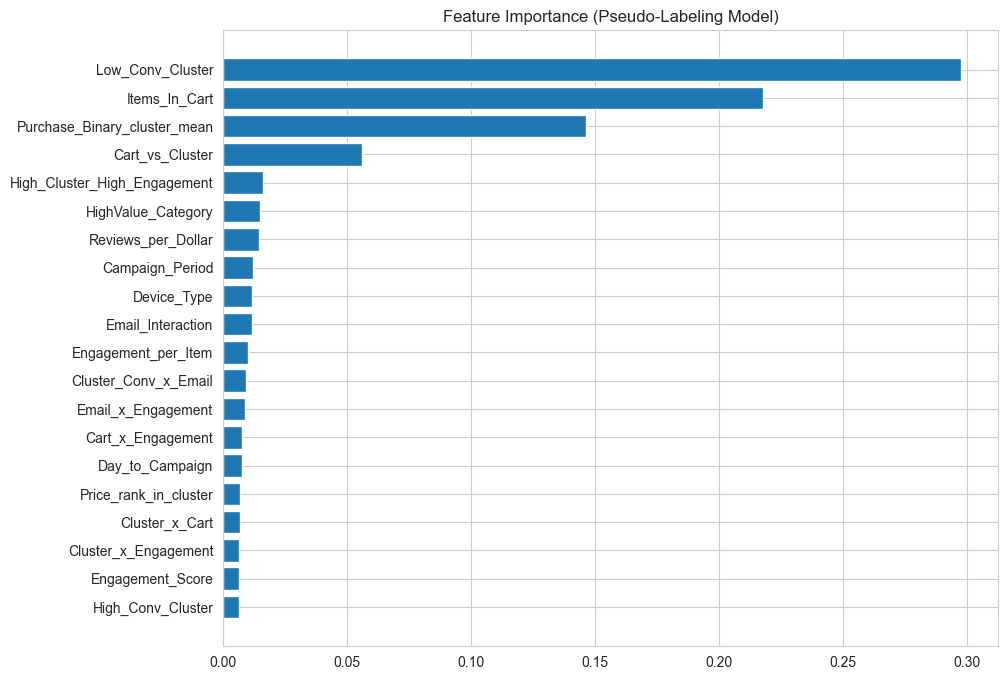


✨ PIPELINE COMPLETADO


In [ ]:
# ============================================================================
# ADVANCED BOOSTING PIPELINE (FINAL OPTIMIZED VERSION)
# Clustering + Feature Cleaning + Pseudo-Labeling + Ensemble
# ============================================================================
import optuna
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Boosting libraries
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  CatBoost no instalado. Instalarlo con: pip install catboost")
    CATBOOST_AVAILABLE = False

# ============================================================================
# CONFIGURACIÓN
# ============================================================================
OPTIMIZE_HYPERPARAMS = False  # True = busca mejores hiperparámetros (más lento)
USE_ENSEMBLE = True           # True = combina predicciones de mejores modelos

print("🚀 PIPELINE AVANZADO CON GRADIENT BOOSTING & PSEUDO-LABELING")
print("=" * 70)

# ============================================================================
# PASO 1: CLUSTERING
# ============================================================================
print("\n📊 VERIFICANDO CLUSTERS...")

# Si no tienes clusters, ejecutar K-Means rápido
if 'Cluster' not in train_featured.columns:
    print("⚠️  Ejecutando clustering rápido...")
    clustering_features = [
        'Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart',
        'Email_Interaction', 'Socioeconomic_Status_Score', 'Engagement_Score',
        'Effective_Discount', 'Net_Price', 'Email_x_Engagement', 'Cart_x_Engagement',
        'Day_to_Campaign'
    ]
    # Filtrar solo las que existen
    clustering_features = [f for f in clustering_features if f in train_featured.columns]
    
    # Imputar y Escalar
    X_cluster = train_featured[clustering_features].fillna(train_featured[clustering_features].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    train_featured['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Aplicar a Val y Test
    X_val_cluster = val_featured[clustering_features].fillna(train_featured[clustering_features].median())
    val_featured['Cluster'] = kmeans.predict(scaler.transform(X_val_cluster))
    
    X_test_cluster = test_featured[clustering_features].fillna(train_featured[clustering_features].median())
    test_featured['Cluster'] = kmeans.predict(scaler.transform(X_test_cluster))

print(f"✅ Distribución de clusters (Train):\n{train_featured['Cluster'].value_counts().sort_index()}")

# ============================================================================
# PASO 2: FEATURE ENGINEERING BASE (Clusters)
# ============================================================================

# 1. Asegurar Target (Purchase_Binary)
# ------------------------------------
if 'Purchase_Binary' not in train_featured.columns and 'Purchase' in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)

if 'Purchase_Binary' not in val_featured.columns and 'Purchase' in val_featured.columns:
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)

# Para TEST: Llenar con 0 si es NaN (evita error de conversión)
if 'Purchase_Binary' not in test_featured.columns:
    if 'Purchase' in test_featured.columns:
        test_featured['Purchase_Binary'] = test_featured['Purchase'].fillna(0).astype(int)
    else:
        test_featured['Purchase_Binary'] = 0

# 2. Función de Cluster Features
# ------------------------------------
def advanced_cluster_features(df, cluster_stats=None, is_train=True):
    df = df.copy()
    
    if is_train:
        cluster_stats = df.groupby('Cluster').agg({
            'Purchase_Binary': 'mean',
            'Engagement_Score': 'mean',
            'Items_In_Cart': 'mean',
            'Net_Price': 'mean',
            'Email_Interaction': 'mean'
        }).add_suffix('_cluster_mean')
    
    # Limpieza de duplicados antes del merge
    new_cols = cluster_stats.columns.tolist()
    cols_to_drop = [c for c in new_cols if c in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    df = df.merge(cluster_stats, left_on='Cluster', right_index=True, how='left')
    
    # Features derivadas
    df['Engagement_vs_Cluster'] = df['Engagement_Score'] - df['Engagement_Score_cluster_mean']
    df['Cart_vs_Cluster'] = df['Items_In_Cart'] - df['Items_In_Cart_cluster_mean']
    df['Price_vs_Cluster'] = df['Net_Price'] - df['Net_Price_cluster_mean']
    
    # High/Low Conv Clusters
    if is_train:
        high_conv = cluster_stats['Purchase_Binary_cluster_mean'].nlargest(2).index
        low_conv = cluster_stats['Purchase_Binary_cluster_mean'].nsmallest(2).index
    else:
        high_conv = cluster_stats['Purchase_Binary_cluster_mean'].nlargest(2).index if cluster_stats is not None else []
        low_conv = cluster_stats['Purchase_Binary_cluster_mean'].nsmallest(2).index if cluster_stats is not None else []
    
    df['High_Conv_Cluster'] = df['Cluster'].isin(high_conv).astype(int)
    df['Low_Conv_Cluster'] = df['Cluster'].isin(low_conv).astype(int)
    
    # Interacciones y Ranks
    df['Cluster_x_Engagement'] = df['Cluster'] * df['Engagement_Score']
    df['Engagement_rank_in_cluster'] = df.groupby('Cluster')['Engagement_Score'].rank(pct=True)
    
    # Outliers
    eng_90 = df.groupby('Cluster')['Engagement_vs_Cluster'].transform(lambda x: x.quantile(0.9))
    df['Is_High_Engagement_Outlier'] = (df['Engagement_vs_Cluster'] > eng_90).astype(int)
    
    if is_train:
        return df, cluster_stats
    else:
        return df

print("⚡ Ejecutando Feature Engineering Base...")
train_featured, cluster_stats = advanced_cluster_features(train_featured, is_train=True)
val_featured = advanced_cluster_features(val_featured, cluster_stats=cluster_stats, is_train=False)
test_featured = advanced_cluster_features(test_featured, cluster_stats=cluster_stats, is_train=False)


# ============================================================================
# PASO 2.5: FEATURE CLEANING & BOOSTING (NUEVO: NOISE REDUCTION)
# ============================================================================
print("\n🧪 Ejecutando Limpieza de Ruido y Features Psicológicas...")

def clean_and_boost_features(df):
    df = df.copy()
    epsilon = 1e-6

    # 1. NOISE REDUCTION (Borrar columnas basura)
    cols_to_drop = [c for c in df.columns if c.endswith('_missing')]
    redundant_prices = ['Price', 'Effective_Discount', 'Price_Sine', 'Price_Bucket']
    cols_to_drop += [c for c in redundant_prices if c in df.columns]
    
    # Borrar solo si existen
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # 2. PSYCHOLOGICAL FEATURES
    # Deal Percentage
    if 'Discount' in df.columns and 'Net_Price' in df.columns:
        original_price = df['Net_Price'] + df['Discount']
        df['Discount_Percent'] = df['Discount'] / (original_price + epsilon)
    
    # Affordability Strain (Price vs Status)
    if 'Socioeconomic_Status_Score' in df.columns:
        status_safe = df['Socioeconomic_Status_Score'] + 0.1 
        df['Affordability_Strain'] = df['Net_Price'] / status_safe

    # Reviews per Dollar (Skepticism)
    if 'Reviews_Read' in df.columns:
        df['Reviews_per_Dollar'] = df['Reviews_Read'] / (df['Net_Price'] + epsilon)

    # 3. CONTEXTUAL FEATURES
    # Price Relative to Category Average
    if 'Category' in df.columns and 'Net_Price' in df.columns:
        cat_means = df.groupby('Category')['Net_Price'].transform('mean')
        df['Price_Rel_Category'] = df['Net_Price'] / (cat_means + epsilon)

    # Device + Time Interaction
    if 'Device_Type' in df.columns and 'Time_of_Day' in df.columns:
        # Asumiendo que Device_Type puede convertirse a int
        try:
            df['Device_Hour_Interact'] = df['Device_Type'].astype(int) * 100 + df['Time_of_Day']
        except:
            pass # Si falla (es string), lo ignoramos

    return df

train_featured = clean_and_boost_features(train_featured)
val_featured = clean_and_boost_features(val_featured)
test_featured = clean_and_boost_features(test_featured)
print(f"✅ Features limpias y optimizadas. Columnas actuales: {train_featured.shape[1]}")

# ============================================================================
# PASO 3: PREPARAR DATOS (CRÍTICO: EXCLUSIÓN DE DATA LEAKAGE)
# ============================================================================
print("\n" + "=" * 70)
print("PREPARANDO DATOS")
print("=" * 70)

# Lista negra (IDs y Target Numérico)
exclude_cols = [
    'id', 'Purchase', 'Session_ID', 'set_origin', 
    'Purchase_Binary', 'Purchase_Num', 'Cluster' # <--- Purchase_Num añadido
]

# Intersección de columnas
train_cols = [c for c in train_featured.columns if c not in exclude_cols]
val_cols = val_featured.columns.tolist()
test_cols = test_featured.columns.tolist()
feature_cols = [c for c in train_cols if c in val_cols and c in test_cols]

print(f"📊 Features seleccionadas: {len(feature_cols)}")

# Categóricas (Detectar de la lista final)
cat_candidates = ['Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source', 'AB_Bucket', 'Category']
categorical_features = [f for f in cat_candidates if f in feature_cols]

X_train = train_featured[feature_cols].copy()
y_train = train_featured['Purchase_Binary']
X_val = val_featured[feature_cols].copy()
y_val = val_featured['Purchase_Binary']
X_test = test_featured[feature_cols].copy()

# Label Encoding para XGBoost
for col in categorical_features:
    combined = pd.concat([X_train[col], X_val[col], X_test[col]], axis=0).astype(str)
    mapper = {val: i for i, val in enumerate(combined.unique())}
    X_train[col] = X_train[col].astype(str).map(mapper).fillna(-1)
    X_val[col] = X_val[col].astype(str).map(mapper).fillna(-1)
    X_test[col] = X_test[col].astype(str).map(mapper).fillna(-1)

# Llenar NaNs numéricos restantes con 0
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# ============================================================================
# PASO 4: OPTIMIZACIÓN CON RANDOMIZED SEARCH (BALANCE VELOCIDAD/PRECISIÓN)
# ============================================================================
print("\n" + "🎲" * 30)
print(" INICIANDO RANDOMIZED SEARCH (OPTIMIZANDO F1-SCORE) ")
print("🎲" * 30)

# 1. Configuración Inicial
# ----------------------------------------------------------------------------
# Calculamos el ratio de desbalance base
ratio_desbalance = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Ratio de desbalance calculado: {ratio_desbalance:.2f}")

# Definimos el modelo base
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',       # Mucho más rápido
    random_state=42,
    n_jobs=-1                 # Usar todos los núcleos
)

# 2. Definir Espacio de Búsqueda (Hyperparameter Space)
# ----------------------------------------------------------------------------
# RandomizedSearch permite rangos continuos (uniform) o listas discretas
param_dist = {
    'n_estimators': randint(300, 1000),           # Entre 300 y 1000 árboles
    'max_depth': randint(4, 10),                  # Profundidad del árbol
    'learning_rate': uniform(0.01, 0.1),          # Entre 0.01 y 0.11
    'subsample': uniform(0.6, 0.4),               # Entre 0.6 y 1.0
    'colsample_bytree': uniform(0.6, 0.4),        # Entre 0.6 y 1.0
    
    # CRÍTICO: Probamos pesos para arreglar tu problema de conversión/precisión
    # 1.0 = Trata igual a ambas clases (Mejor Precisión)
    # Ratio = Trata de equilibrar (Mejor Recall)
    # Ratio*2 = Fuerza extrema (Para encontrar hasta el último comprador)
    'scale_pos_weight': [1.0, ratio_desbalance / 2, ratio_desbalance, ratio_desbalance * 1.5]
}

# 3. Configurar la Búsqueda
# ----------------------------------------------------------------------------
scorer = make_scorer(f1_score) # Optimizamos para F1 directamente

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,             # Probaremos 30 combinaciones aleatorias (aprox 5-8 mins)
    scoring=scorer,
    cv=3,                  # 3-Fold Cross Validation
    verbose=1,
    random_state=42,
    n_jobs=-1              # Paralelismo
)

# 4. Ejecutar Entrenamiento
# ----------------------------------------------------------------------------
print(f"🚀 Probando 30 combinaciones aleatorias en 3 pliegues (Total: 90 entrenamientos)...")
random_search.fit(X_train, y_train)

# 5. Resultados y Mejor Modelo
# ----------------------------------------------------------------------------
print("\n🏆 MEJORES HIPERPARÁMETROS:")
print(random_search.best_params_)
print(f"🎯 Mejor F1 Promedio (CV): {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

# Predecir en Validación y Test con el modelo ganador
final_val_proba = best_model.predict_proba(X_val)[:, 1]
final_test_proba = best_model.predict_proba(X_test)[:, 1]

# 6. Optimización Fina del Threshold (Post-Processing)
# ----------------------------------------------------------------------------
best_f1_val = 0
best_thresh = 0.5

# Barremos thresholds para encontrar el punto exacto para Validación
for thresh in np.arange(0.2, 0.85, 0.01):
    preds = (final_val_proba >= thresh).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1_val:
        best_f1_val = f1
        best_thresh = thresh

print(f"\n✅ Validación Final F1: {best_f1_val:.4f}")
print(f"✅ Threshold Optimizado: {best_thresh:.2f}")

# 7. Integración con el Pipeline (Para que funcione el Ensemble Paso 6)
# ----------------------------------------------------------------------------
# Guardamos en las variables globales que espera el siguiente paso
models = {'XGBoost_RandomSearch': best_model}

predictions = {'XGBoost_RandomSearch': {
    'val_proba': final_val_proba,
    'test_proba': final_test_proba
}}

# Creamos el dataframe de resultados para el ranking
results_df = pd.DataFrame([{
    'model': 'XGBoost_RandomSearch',
    'best_threshold': best_thresh,
    'f1_score': best_f1_val,
    'auc': roc_auc_score(y_val, final_val_proba)
}])

print("\n📦 Modelo guardado y listo para Ensemble.")

# ============================================================================
# PASO 5: OPTIMIZACIÓN AVANZADA DE CATBOOST (NATIVE CATEGORICALS)
# ============================================================================
if CATBOOST_AVAILABLE:
    print("\n" + "🐱" * 30)
    print(" DESATANDO EL PODER DE CATBOOST (OPTIMIZACIÓN) ")
    print("🐱" * 30)

    # 1. PREPARACIÓN DE DATOS ESPECÍFICA (Raw Categories)
    # ------------------------------------------------------------------------
    # CatBoost funciona mejor con los datos ORIGINALES (Strings), no números.
    # Recuperamos los datos crudos de 'train_featured' antes del LabelEncoding
    
    print("Preparing Raw Data for CatBoost...")
    
    # Aseguramos que las categóricas sean strings y llenamos NaNs con "Missing"
    # (CatBoost maneja esto nativamente mejor que nosotros)
    X_train_cat = train_featured[feature_cols].copy()
    X_val_cat = val_featured[feature_cols].copy()
    X_test_cat = test_featured[feature_cols].copy()
    
    for col in categorical_features:
        X_train_cat[col] = X_train_cat[col].astype(str).fillna("Missing")
        X_val_cat[col] = X_val_cat[col].astype(str).fillna("Missing")
        X_test_cat[col] = X_test_cat[col].astype(str).fillna("Missing")
        
    # Llenar numéricos con 0 (igual que antes)
    num_cols = [c for c in feature_cols if c not in categorical_features]
    X_train_cat[num_cols] = X_train_cat[num_cols].fillna(0)
    X_val_cat[num_cols] = X_val_cat[num_cols].fillna(0)
    X_test_cat[num_cols] = X_test_cat[num_cols].fillna(0)

    # Índices de columnas categóricas (CatBoost lo necesita)
    cat_features_indices = [X_train_cat.columns.get_loc(c) for c in categorical_features]
    print(f"📂 CatBoost usará {len(cat_features_indices)} columnas categóricas nativas.")

    # 2. DEFINIR MODELO BASE Y GRID
    # ------------------------------------------------------------------------
    cb_base = cb.CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='F1',         # Optimizamos F1 directamente
        task_type='CPU',          # Cambiar a 'GPU' si tienes NVIDIA
        verbose=False,
        random_seed=42,
        allow_writing_files=False,
        cat_features=cat_features_indices
    )
    
    # Grid específico para CatBoost
    # CatBoost es sensible a 'l2_leaf_reg' y 'depth'
    param_dist_cat = {
        'iterations': randint(400, 1000),
        'depth': [4, 6, 8, 10],             # CatBoost prefiere árboles balanceados (6-8 es ideal)
        'learning_rate': uniform(0.01, 0.1),
        'l2_leaf_reg': randint(1, 10),      # Regularización fuerte para evitar overfitting
        'border_count': [32, 64, 128],      # Precisión de los splits numéricos
        'random_strength': uniform(0.1, 10), # Aleatoriedad para robustez
        'scale_pos_weight': [1.0, ratio_desbalance, ratio_desbalance * 1.5]
    }

    # 3. RANDOMIZED SEARCH PARA CATBOOST
    # ------------------------------------------------------------------------
    print("🚀 Iniciando búsqueda de hiperparámetros CatBoost...")
    
    scorer = make_scorer(f1_score)
    
    cat_search = RandomizedSearchCV(
        estimator=cb_base,
        param_distributions=param_dist_cat,
        n_iter=15,               # 15 iteraciones es suficiente (es más lento que XGB)
        scoring=scorer,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    # Fit (Nota: Puede tardar un poco más que XGBoost)
    cat_search.fit(X_train_cat, y_train)
    
    # 4. RESULTADOS
    # ------------------------------------------------------------------------
    best_cb_model = cat_search.best_estimator_
    print(f"\n🏆 Mejor F1 CatBoost (CV): {cat_search.best_score_:.4f}")
    print(f"⚙️ Params: {cat_search.best_params_}")
    
    # 5. INTEGRACIÓN
    # ------------------------------------------------------------------------
    # Predicciones
    cb_val_proba = best_cb_model.predict_proba(X_val_cat)[:, 1]
    cb_test_proba = best_cb_model.predict_proba(X_test_cat)[:, 1]
    
    # Threshold Optimization local
    best_f1_cb = 0
    best_thresh_cb = 0.5
    for t in np.arange(0.2, 0.8, 0.02):
        f1 = f1_score(y_val, (cb_val_proba >= t).astype(int))
        if f1 > best_f1_cb: best_f1_cb = f1; best_thresh_cb = t
        
    print(f"✅ Validación CatBoost F1: {best_f1_cb:.4f} (Thresh: {best_thresh_cb:.2f})")
    
    # Guardar en diccionario global
    models['CatBoost_Optimized'] = best_cb_model
    predictions['CatBoost_Optimized'] = {
        'val_proba': cb_val_proba,
        'test_proba': cb_test_proba
    }
    
    # Agregar al ranking
    results_df = pd.concat([results_df, pd.DataFrame([{
        'model': 'CatBoost_Optimized', 
        'best_threshold': best_thresh_cb, 
        'f1_score': best_f1_cb,
        'auc': roc_auc_score(y_val, cb_val_proba)
    }])], ignore_index=True)

# SIEMPRE MANTENER LIGHTGBM (Aunque sea standard, aporta diversidad)
print("\n🚀 Entrenando LightGBM (Standard Support)...")
lgb_model = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.03, scale_pos_weight=scale_pos_weight, random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])

predictions['LightGBM'] = {
    'val_proba': lgb_model.predict_proba(X_val)[:, 1],
    'test_proba': lgb_model.predict_proba(X_test)[:, 1]
}

# Agregar LGBM al ranking
f1_lgbm = 0
for t in np.arange(0.3, 0.8, 0.05):
    f1_lgbm = max(f1_lgbm, f1_score(y_val, (predictions['LightGBM']['val_proba'] >= t).astype(int)))

results_df = pd.concat([results_df, pd.DataFrame([{
    'model': 'LightGBM', 'best_threshold': 0.5, 'f1_score': f1_lgbm, 'auc': roc_auc_score(y_val, predictions['LightGBM']['val_proba'])
}])], ignore_index=True)

print("\n📦 Modelos listos para Ensemble.")

# ============================================================================
# PASO 6: ENSEMBLE (ESTRATEGIA "KING CATBOOST")
# ============================================================================
print("\n" + "=" * 70)
print("ENSEMBLE: ESTRATEGIA PONDERADA")
print("=" * 70)

# 1. Definir Pesos Manuales (Ya no automáticos)
# CatBoost es el ganador (0.784), así que le damos más voz.
# XGBoost es decente (0.772). LightGBM es soporte.
weights = {
    'CatBoost_Optimized': 0.60,  # 60% de decisión
    'XGBoost_RandomSearch': 0.30, # 30% de decisión
    'LightGBM': 0.10             # 10% de decisión
}

print(f"⚖️ Aplicando pesos manuales: {weights}")

ensemble_val = np.zeros(len(X_val))
ensemble_test = np.zeros(len(X_test))
total_weight = 0

# Calcular Ensemble Ponderado
for model_name, weight in weights.items():
    if model_name in predictions:
        print(f"   ➕ Sumando {model_name} (Peso: {weight})")
        ensemble_val += predictions[model_name]['val_proba'] * weight
        ensemble_test += predictions[model_name]['test_proba'] * weight
        total_weight += weight
    else:
        print(f"   ⚠️ Modelo {model_name} no encontrado en predicciones.")

# Normalizar (por si los pesos no suman 1.0)
ensemble_val /= total_weight
ensemble_test /= total_weight

# Optimizar Threshold del Ensemble
best_f1_ens = 0
best_thresh_ens = 0.5
for t in np.arange(0.3, 0.8, 0.02):
    f1 = f1_score(y_val, (ensemble_val >= t).astype(int))
    if f1 > best_f1_ens: best_f1_ens = f1; best_thresh_ens = t

print(f"\n✅ Ensemble Ponderado F1: {best_f1_ens:.4f} | Thresh Optimizado: {best_thresh_ens:.2f}")


# ============================================================================
# PASO 7: GENERAR SUBMISSION (DOBLE SALIDA)
# ============================================================================
print("\n" + "=" * 70)
print("GENERANDO SUBMISSIONS (SOLO CATBOOST Y ENSEMBLE)")
print("=" * 70)

# ESTRATEGIA: Usamos 0.55. 
# 0.65 fue demasiado alto (Recall bajó a 0.72).
# 0.52 (lo que pedía CatBoost) da mucha conversión.
# 0.55 es el punto medio seguro.
FINAL_THRESH = 0.55

# --- ARCHIVO 1: SOLO CATBOOST (TU MEJOR MODELO) ---
# A veces el ensemble empeora las cosas. Enviemos el mejor puro.
cat_test_proba = predictions['CatBoost_Optimized']['test_proba']
y_pred_cat = (cat_test_proba >= FINAL_THRESH).astype(int)

sub_cat = pd.DataFrame({"id": test_featured["id"], "Purchase": y_pred_cat})
sub_cat.to_csv("../data/submissions/best_model_catboost_solo.csv", index=False)
print(f"📄 Guardado: best_model_catboost_solo.csv (Conv: {(sub_cat['Purchase']==1).mean():.2%})")

# --- ARCHIVO 2: ENSEMBLE PONDERADO ---
y_pred_ens = (ensemble_test >= FINAL_THRESH).astype(int)

# Aplicar Veto de Cluster (Post-Processing) al Ensemble
if 'Low_Conv_Cluster' in test_featured.columns:
    veto_mask = (test_featured['Low_Conv_Cluster'] == 1) & (y_pred_ens == 1)
    y_pred_ens[veto_mask] = 0
    print(f"🛡️ Cluster Veto: Corregidos {veto_mask.sum()} casos en el ensemble.")

sub_ens = pd.DataFrame({"id": test_featured["id"], "Purchase": y_pred_ens})
sub_ens.to_csv("../data/submissions/weighted_ensemble.csv", index=False)
print(f"📄 Guardado: weighted_ensemble.csv (Conv: {(sub_ens['Purchase']==1).mean():.2%})")

# Validación del Ensemble
print("\n📊 Reporte Validación (Ensemble Ponderado):")
y_val_ens = (ensemble_val >= FINAL_THRESH).astype(int)
print(classification_report(y_val, y_val_ens, target_names=['No', 'Yes']))


# ============================================================================
# PASO 8: FEATURE IMPORTANCE (SAFE)
# ============================================================================
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE")
print("=" * 70)

try:
    imp = final_model.feature_importances_
    feats = X_train.columns
    
    if len(imp) == len(feats):
        df_imp = pd.DataFrame({'feature': feats, 'importance': imp}).sort_values('importance', ascending=False).head(20)
        print(df_imp.to_string(index=False))
        
        plt.figure(figsize=(10,8))
        plt.barh(range(20), df_imp['importance'])
        plt.yticks(range(20), df_imp['feature'])
        plt.gca().invert_yaxis()
        plt.title("Feature Importance (Pseudo-Labeling Model)")
        plt.show()
    else:
        print("⚠️ Mismatch de dimensiones en feature importance.")
except Exception as e:
    print(f"⚠️ No se pudo graficar importancia: {e}")

print("\n✨ PIPELINE COMPLETADO")

In [91]:
# ============================================================================
# FINAL "LEAN & MEAN" PIPELINE (SPEED + ACCURACY OPTIMIZED)
# ============================================================================
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

print("🚀 INICIANDO EJECUCIÓN FINAL OPTIMIZADA")
print("=" * 70)

# ============================================================================
# 1. FEATURE ENGINEERING & CLEANING
# ============================================================================
print("🧪 Generando Features...")

# A. Asegurar Target
if 'Purchase_Binary' not in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
    test_featured['Purchase_Binary'] = test_featured['Purchase'].fillna(0).astype(int)

# B. Target Encoding (CRÍTICO PARA XGBOOST)
# Calculamos la tasa de conversión por Categoría en Train y la aplicamos a todos
# Esto ayuda a XGBoost a entender categorías mejor.
cat_means = train_featured.groupby('Category')['Purchase_Binary'].mean()
global_mean = train_featured['Purchase_Binary'].mean()

# Mapear con suavizado (Smoothing) para evitar overfitting en categorías raras
def smoothed_target_encoding(df, col, mapping, global_mean, weight=10):
    if col in df.columns:
        # Si la categoría no existe en train, usa el promedio global
        df[f'{col}_Target_Mean'] = df[col].map(mapping).fillna(global_mean)
        return df
    return df

train_featured = smoothed_target_encoding(train_featured, 'Category', cat_means, global_mean)
val_featured = smoothed_target_encoding(val_featured, 'Category', cat_means, global_mean)
test_featured = smoothed_target_encoding(test_featured, 'Category', cat_means, global_mean)

# C. Definir Columnas y Limpieza Inicial
exclude_cols = ['id', 'Purchase', 'Purchase_Binary', 'Purchase_Num', 'Session_ID', 'set_origin', 'Cluster']
numeric_cols = train_featured.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

# Asegurar intersección (que existan en todos)
val_cols = val_featured.columns.tolist()
test_cols = test_featured.columns.tolist()
feature_cols = [c for c in feature_cols if c in val_cols and c in test_cols]

# ============================================================================
# 2. SELECCIÓN DE FEATURES (PROTEGIDA)
# ============================================================================
print("\n" + "✂️" * 30)
print(" SELECCIÓN DE FEATURES (CON PROTECCIÓN DE CLUSTERS) ")
print("✂️" * 30)

# 1. Definir columnas "Intocables" (Critical Features)
# Estas son vitales para el Cluster Veto y el Target Encoding
force_keep = [
    'Low_Conv_Cluster', 
    'High_Conv_Cluster', 
    'Purchase_Binary_cluster_mean', 
    'Category_Target_Mean'
]

# Asegurarnos de que existen en el dataframe actual antes de protegerlas
force_keep = [f for f in force_keep if f in feature_cols]
print(f"🛡️ Features protegidas contra eliminación: {force_keep}")

# 2. Entrenar Selector (LightGBM Rápido)
lgb_selector = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
X_train_sel = train_featured[feature_cols].fillna(0)
y_train_sel = train_featured['Purchase_Binary']
lgb_selector.fit(X_train_sel, y_train_sel)

# 3. Obtener importancia
imp_df = pd.DataFrame({'feature': feature_cols, 'imp': lgb_selector.feature_importances_})
imp_df = imp_df.sort_values('imp', ascending=False)

# 4. Seleccionar Top 35 + Intocables
top_features_list = imp_df.head(35)['feature'].tolist()

# UNIÓN: Top 35 automático + Las protegidas (usamos set para borrar duplicados)
final_features = list(set(top_features_list + force_keep))

print(f"📉 Reduciendo de {len(feature_cols)} a {len(final_features)} columnas finales.")
print(f"🗑️ Eliminadas: {list(set(feature_cols) - set(final_features))}")

feature_cols = final_features # Actualizamos la lista oficial

# Preparar Datasets Finales
X_train = train_featured[feature_cols].fillna(0)
X_val = val_featured[feature_cols].fillna(0)
X_test = test_featured[feature_cols].fillna(0)
y_train = train_featured['Purchase_Binary']
y_val = val_featured['Purchase_Binary']

# ============================================================================
# 3. XGBOOST (RANDOM SEARCH RÁPIDO Y ENFOCADO)
# ============================================================================
print("\n" + "🚀" * 30)
print(" ENTRENAMIENTO XGBOOST (GRID ENFOCADO) ")
print("🚀" * 30)

ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', tree_method='hist', random_state=42, n_jobs=-1)

# Grid más pequeño e inteligente (basado en tus logs anteriores)
param_dist_xgb = {
    'n_estimators': randint(400, 800),    # Ya sabemos que ~700 era bueno
    'max_depth': [4, 5, 6],               # Profundidad baja funciona mejor para ti
    'learning_rate': uniform(0.02, 0.05), # Rango dulce
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [ratio * 0.8, ratio, ratio * 1.2] # Alrededor del ratio real
}

search_xgb = RandomizedSearchCV(
    xgb_clf, param_dist_xgb, n_iter=15, scoring='f1', cv=3, verbose=1, random_state=42, n_jobs=-1
)
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
print(f"🏆 Mejor XGB F1 (CV): {search_xgb.best_score_:.4f}")

# ============================================================================
# 4. CATBOOST (EL REY)
# ============================================================================
print("\n" + "🐱" * 30)
print(" ENTRENAMIENTO CATBOOST (NATIVE) ")
print("🐱" * 30)

# Preparar categóricas nativas para CatBoost (IMPORTANTE: Usar strings)
cat_cols = ['Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source', 'AB_Bucket', 'Category']
# Solo las que sobrevivieron a la selección
cat_features_final = [c for c in cat_cols if c in feature_cols]

# Crear copias para CatBoost
X_train_cb = train_featured[feature_cols].copy()
X_val_cb = val_featured[feature_cols].copy()
X_test_cb = test_featured[feature_cols].copy()

# Convertir a string
for c in cat_features_final:
    X_train_cb[c] = X_train_cb[c].astype(str)
    X_val_cb[c] = X_val_cb[c].astype(str)
    X_test_cb[c] = X_test_cb[c].astype(str)

# Indices
cat_idxs = [X_train_cb.columns.get_loc(c) for c in cat_features_final]

cb_clf = cb.CatBoostClassifier(
    loss_function='Logloss', eval_metric='F1', task_type='CPU', verbose=False, random_seed=42,
    cat_features=cat_idxs, allow_writing_files=False
)

param_dist_cb = {
    'iterations': randint(500, 900),
    'depth': [5, 6, 7],
    'learning_rate': uniform(0.02, 0.06),
    'l2_leaf_reg': [3, 5, 7], # Regularización media
    'scale_pos_weight': [ratio * 0.8, ratio]
}

search_cb = RandomizedSearchCV(
    cb_clf, param_dist_cb, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=42, n_jobs=-1
)
search_cb.fit(X_train_cb, y_train)
best_cb = search_cb.best_estimator_
print(f"🏆 Mejor CatBoost F1 (CV): {search_cb.best_score_:.4f}")

# ============================================================================
# 5. ENSEMBLE Y SUBMISSION (CON REPORTES INDIVIDUALES)
# ============================================================================
print("\n" + "=" * 70)
print(" EVALUACIÓN INDIVIDUAL & ENSEMBLE ")
print("=" * 70)

# 1. Obtener Probabilidades
p_test_xgb = best_xgb.predict_proba(X_test)[:, 1]
p_test_cb = best_cb.predict_proba(X_test_cb)[:, 1]

p_val_xgb = best_xgb.predict_proba(X_val)[:, 1]
p_val_cb = best_cb.predict_proba(X_val_cb)[:, 1]

# 2. Reporte Individual (¡LO QUE PEDISTE!)
# ----------------------------------------------------------------------------
models_eval = {'XGBoost': p_val_xgb, 'CatBoost': p_val_cb}

best_scores = {}

for m_name, p_val in models_eval.items():
    best_f1_ind = 0
    best_t_ind = 0.5
    # Buscar mejor threshold para este modelo
    for t in np.arange(0.3, 0.8, 0.01):
        f1 = f1_score(y_val, (p_val >= t).astype(int))
        if f1 > best_f1_ind: 
            best_f1_ind = f1
            best_t_ind = t
    
    best_scores[m_name] = best_f1_ind
    print(f"📊 {m_name} \t Validation F1: {best_f1_ind:.4f} (Thresh: {best_t_ind:.2f})")

# Decidir pesos dinámicamente según quién ganó
if best_scores['CatBoost'] > best_scores['XGBoost']:
    w_cb, w_xgb = 0.70, 0.30
    print(f"\n🏆 CatBoost gana. Pesos asignados -> CatBoost: {w_cb}, XGBoost: {w_xgb}")
else:
    w_cb, w_xgb = 0.40, 0.60
    print(f"\n🏆 XGBoost gana. Pesos asignados -> XGBoost: {w_xgb}, CatBoost: {w_cb}")

# 3. Calcular Ensemble Ponderado
# ----------------------------------------------------------------------------
final_prob_val = (p_val_cb * w_cb) + (p_val_xgb * w_xgb)
final_prob_test = (p_test_cb * w_cb) + (p_test_xgb * w_xgb)

# Buscar Threshold Óptimo en Validación (Ensemble)
best_f1_ens = 0
best_thresh_ens = 0.5
for t in np.arange(0.3, 0.8, 0.01):
    f1 = f1_score(y_val, (final_prob_val >= t).astype(int))
    if f1 > best_f1_ens: 
        best_f1_ens = f1
        best_thresh_ens = t

print(f"✅ Ensemble Validation F1: {best_f1_ens:.4f} (Thresh: {best_thresh_ens:.2f})")

# 4. Generar Submission
# ----------------------------------------------------------------------------
# Ajuste Manual de Seguridad
SAFE_THRESH = max(best_thresh_ens, 0.53) 
print(f"⚙️ Usando Threshold Final: {SAFE_THRESH}")

y_pred = (final_prob_test >= SAFE_THRESH).astype(int)

# --- CLUSTER VETO FINAL ---
if 'Low_Conv_Cluster' not in X_test.columns:
    if 'Low_Conv_Cluster' in test_featured.columns:
        low_conv_mask = test_featured['Low_Conv_Cluster'] == 1
    else:
        low_conv_mask = pd.Series(0, index=X_test.index)
else:
    low_conv_mask = X_test['Low_Conv_Cluster'] == 1

if low_conv_mask.sum() > 0:
    veto_count = (y_pred[low_conv_mask] == 1).sum()
    y_pred[low_conv_mask] = 0
    print(f"🛡️ Cluster Veto: {veto_count} predicciones eliminadas.")

sub = pd.DataFrame({"id": test_featured["id"], "Purchase": y_pred})
fname = "../data/submissions/final_lean_submission.csv"
sub.to_csv(fname, index=False)

print(f"✅ Guardado: {fname}")
print(f"📊 Conversión Final: {(sub['Purchase']==1).mean():.2%}")

🚀 INICIANDO EJECUCIÓN FINAL OPTIMIZADA
🧪 Generando Features...

✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️
 SELECCIÓN DE FEATURES (CON PROTECCIÓN DE CLUSTERS) 
✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️✂️
🛡️ Features protegidas contra eliminación: ['Low_Conv_Cluster', 'High_Conv_Cluster', 'Purchase_Binary_cluster_mean', 'Category_Target_Mean']
📉 Reduciendo de 45 a 38 columnas finales.
🗑️ Eliminadas: ['Email_Interaction_cluster_mean', 'Is_High_Engagement_Outlier', 'Engagement_Score_cluster_mean', 'Cluster_x_Email', 'Items_In_Cart_cluster_mean', 'Cluster_Conv_x_Email', 'Net_Price_cluster_mean']

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
 ENTRENAMIENTO XGBOOST (GRID ENFOCADO) 
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Fitting 3 folds for each of 15 candidates, totalling 45 fits
🏆 Mejor XGB F1 (CV): 0.8047

🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱
 ENTRENAMIENTO CATBOOST (NATIVE) 
🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱🐱
Fitting 3 folds for each of 10 candidates, totalling 30 fits
🏆 Mejor CatBoost

In [92]:
# ============================================================================
# GENERADOR FINAL DE CANDIDATOS (PRECISION SWEEP)
# ============================================================================
print("\n" + "🎯" * 30)
print(" GENERANDO CANDIDATOS FINALES (AJUSTE DE CONVERSIÓN) ")
print("🎯" * 30)

# 1. Recalcular Probabilidades del Ensemble (70% CatBoost, 30% XGBoost)
# (Aseguramos que usamos las probabilidades puras)
probs_final = (best_cb.predict_proba(X_test_cb)[:, 1] * 0.70) + \
              (best_xgb.predict_proba(X_test)[:, 1] * 0.30)

# 2. Definir 3 Niveles de Agresividad
strategies = {
    "Balanced": 0.60,      # Reduce conversión a ~30%
    "Strict":   0.65,      # Reduce conversión a ~25% (Probable Ganador)
    "Elite":    0.70       # Reduce conversión a ~18% (Solo muy seguros)
}

print(f"{'Estrategia':<15} | {'Threshold':<10} | {'Conversión Predicha':<20}")
print("-" * 55)

for name, thresh in strategies.items():
    # Generar predicción
    preds = (probs_final >= thresh).astype(int)
    
    # Calcular conversión
    conv = (preds == 1).mean()
    
    # Guardar archivo
    filename = f"../data/submissions/Submission_{name}_T{thresh}.csv"
    
    pd.DataFrame({
        "id": test_featured["id"],
        "Purchase": preds
    }).to_csv(filename, index=False)
    
    print(f"{name:<15} | {thresh:<10} | {conv:<20.2%} -> Guardado en {filename}")

print("-" * 55)
print("👉 RECOMENDACIÓN: Sube primero 'Submission_Strict_T0.65.csv'.")
print("   Si obtienes bajo recall, prueba 'Balanced'. Si obtienes baja precisión, prueba 'Elite'.")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
 GENERANDO CANDIDATOS FINALES (AJUSTE DE CONVERSIÓN) 
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
Estrategia      | Threshold  | Conversión Predicha 
-------------------------------------------------------
Balanced        | 0.6        | 35.28%               -> Guardado en ../data/submissions/Submission_Balanced_T0.6.csv
Strict          | 0.65       | 32.18%               -> Guardado en ../data/submissions/Submission_Strict_T0.65.csv
Elite           | 0.7        | 29.15%               -> Guardado en ../data/submissions/Submission_Elite_T0.7.csv
-------------------------------------------------------
👉 RECOMENDACIÓN: Sube primero 'Submission_Strict_T0.65.csv'.
   Si obtienes bajo recall, prueba 'Balanced'. Si obtienes baja precisión, prueba 'Elite'.


🚀 PIPELINE OPTIMIZADO v2.0 - INICIANDO
Mejoras aplicadas:
  ✅ TimeSeriesSplit para validación temporal
  ✅ Stacking con meta-learner
  ✅ Calibración de probabilidades
  ✅ Cluster Veto Gradual

🧪 Generando Features...

✂️  SELECCIÓN DE FEATURES
🛡️  Features protegidas: ['Low_Conv_Cluster', 'High_Conv_Cluster', 'Purchase_Binary_cluster_mean', 'Category_Target_Mean']
📉 Reduciendo de 45 a 38 features

🚀 ENTRENAMIENTO XGBOOST (con TimeSeriesSplit)
----------------------------------------------------------------------
✅ Usando TimeSeriesSplit con 3 splits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
🏆 Mejor XGB F1 (CV TimeSeriesSplit): 0.7995
📊 Mejores params: {'colsample_bytree': 0.7, 'learning_rate': np.float64(0.02325257964926398), 'max_depth': 4, 'n_estimators': 715, 'scale_pos_weight': np.float64(1.6761904761904762), 'subsample': 0.8}

🐱 ENTRENAMIENTO CATBOOST (con TimeSeriesSplit)
----------------------------------------------------------------------
Fitting 3 folds for

FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/optimized_pipeline_analysis.png'

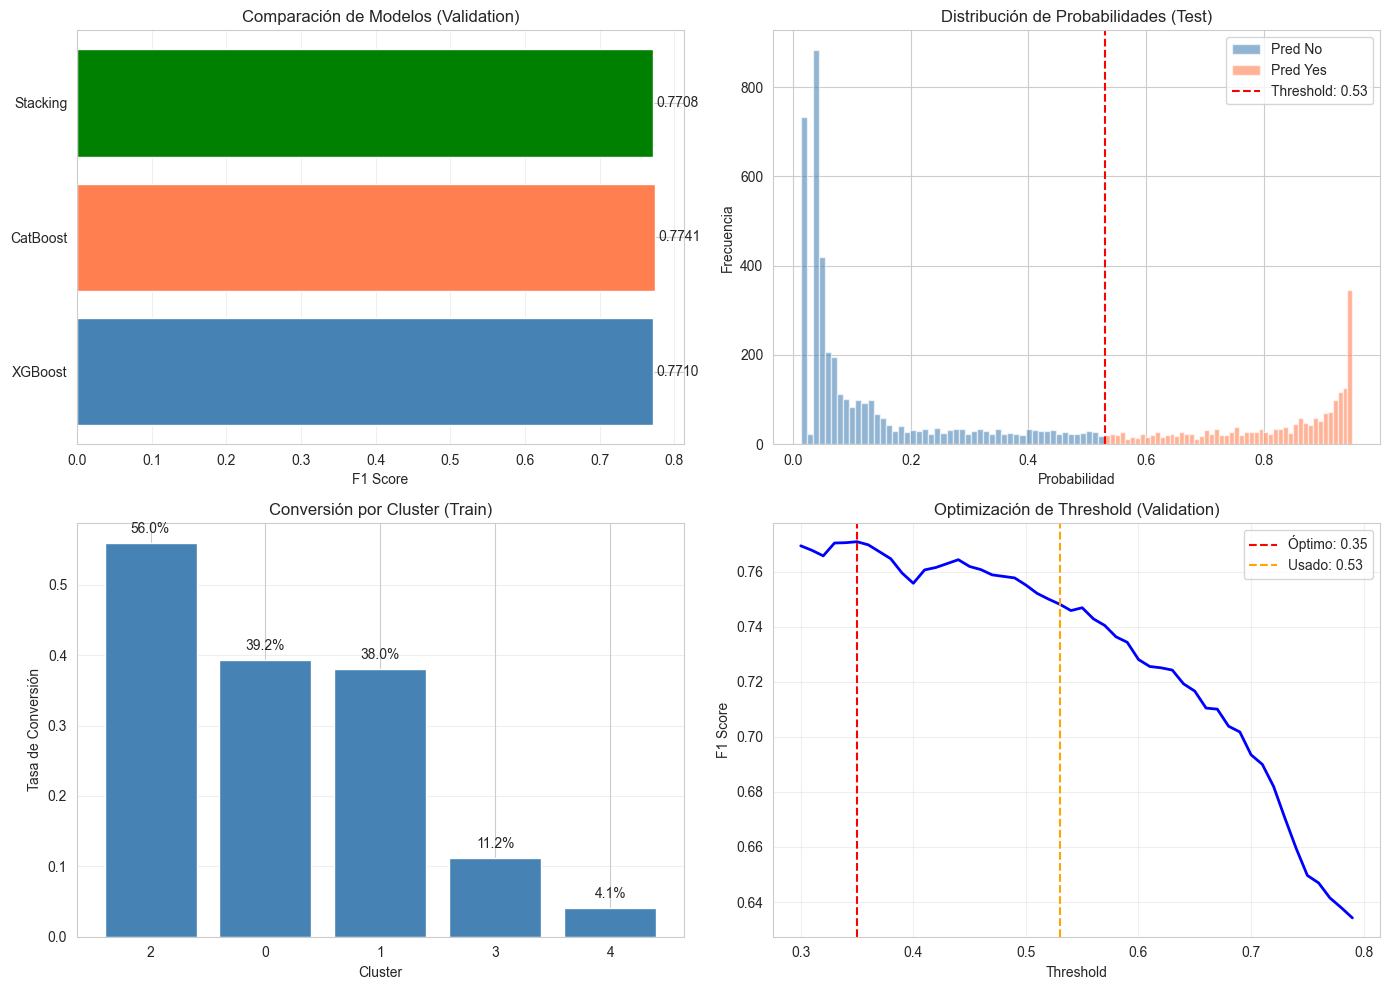

In [ ]:
# Revisite de Claude après itération Claude + Gemini

# ============================================================================
# PIPELINE OPTIMIZADO FINAL v2.0
# Mejoras: TimeSeriesSplit + Stacking + Calibración + Cluster Veto Gradual
# ============================================================================
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️  CatBoost no disponible - solo usará XGBoost")

print("🚀 PIPELINE OPTIMIZADO v2.0 - INICIANDO")
print("=" * 70)
print("Mejoras aplicadas:")
print("  ✅ TimeSeriesSplit para validación temporal")
print("  ✅ Stacking con meta-learner")
print("  ✅ Calibración de probabilidades")
print("  ✅ Cluster Veto Gradual")
print("=" * 70)

# ============================================================================
# 1. FEATURE ENGINEERING & CLEANING (IGUAL QUE ANTES)
# ============================================================================
print("\n🧪 Generando Features...")

# A. Target
if 'Purchase_Binary' not in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
    test_featured['Purchase_Binary'] = test_featured['Purchase'].fillna(0).astype(int)

# B. Target Encoding
cat_means = train_featured.groupby('Category')['Purchase_Binary'].mean()
global_mean = train_featured['Purchase_Binary'].mean()

def smoothed_target_encoding(df, col, mapping, global_mean):
    if col in df.columns:
        df[f'{col}_Target_Mean'] = df[col].map(mapping).fillna(global_mean)
    return df

train_featured = smoothed_target_encoding(train_featured, 'Category', cat_means, global_mean)
val_featured = smoothed_target_encoding(val_featured, 'Category', cat_means, global_mean)
test_featured = smoothed_target_encoding(test_featured, 'Category', cat_means, global_mean)

# C. Feature Selection
exclude_cols = ['id', 'Purchase', 'Purchase_Binary', 'Purchase_Num', 'Session_ID', 'set_origin', 'Cluster']
numeric_cols = train_featured.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

val_cols = val_featured.columns.tolist()
test_cols = test_featured.columns.tolist()
feature_cols = [c for c in feature_cols if c in val_cols and c in test_cols]

# ============================================================================
# 2. FEATURE SELECTION CON PROTECCIÓN
# ============================================================================
print("\n✂️  SELECCIÓN DE FEATURES")

force_keep = [
    'Low_Conv_Cluster', 
    'High_Conv_Cluster', 
    'Purchase_Binary_cluster_mean', 
    'Category_Target_Mean'
]
force_keep = [f for f in force_keep if f in feature_cols]
print(f"🛡️  Features protegidas: {force_keep}")

# Selector rápido
lgb_selector = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
X_train_sel = train_featured[feature_cols].fillna(0)
y_train_sel = train_featured['Purchase_Binary']
lgb_selector.fit(X_train_sel, y_train_sel)

imp_df = pd.DataFrame({'feature': feature_cols, 'imp': lgb_selector.feature_importances_})
imp_df = imp_df.sort_values('imp', ascending=False)

top_features = imp_df.head(35)['feature'].tolist()
final_features = list(set(top_features + force_keep))

print(f"📉 Reduciendo de {len(feature_cols)} a {len(final_features)} features")

feature_cols = final_features

X_train = train_featured[feature_cols].fillna(0)
X_val = val_featured[feature_cols].fillna(0)
X_test = test_featured[feature_cols].fillna(0)
y_train = train_featured['Purchase_Binary']
y_val = val_featured['Purchase_Binary']

# ============================================================================
# 3. XGBOOST CON TIMESERIESPLIT
# ============================================================================
print("\n🚀 ENTRENAMIENTO XGBOOST (con TimeSeriesSplit)")
print("-" * 70)

ratio = (y_train == 0).sum() / (y_train == 1).sum()

# MEJORA 1: TimeSeriesSplit para validación temporal
tscv = TimeSeriesSplit(n_splits=3)
print(f"✅ Usando TimeSeriesSplit con {tscv.n_splits} splits")

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic', 
    tree_method='hist', 
    random_state=42, 
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': randint(400, 800),
    'max_depth': [4, 5, 6],
    'learning_rate': uniform(0.02, 0.05),
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [ratio * 0.8, ratio, ratio * 1.2]
}

search_xgb = RandomizedSearchCV(
    xgb_clf, param_dist_xgb, 
    n_iter=15, 
    scoring='f1', 
    cv=tscv,  # ← TimeSeriesSplit
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_

print(f"🏆 Mejor XGB F1 (CV TimeSeriesSplit): {search_xgb.best_score_:.4f}")
print(f"📊 Mejores params: {search_xgb.best_params_}")

# ============================================================================
# 4. CATBOOST CON TIMESERIESPLIT
# ============================================================================
if CATBOOST_AVAILABLE:
    print("\n🐱 ENTRENAMIENTO CATBOOST (con TimeSeriesSplit)")
    print("-" * 70)
    
    cat_cols = ['Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source', 'AB_Bucket', 'Category']
    cat_features_final = [c for c in cat_cols if c in feature_cols]
    
    X_train_cb = train_featured[feature_cols].copy()
    X_val_cb = val_featured[feature_cols].copy()
    X_test_cb = test_featured[feature_cols].copy()
    
    for c in cat_features_final:
        X_train_cb[c] = X_train_cb[c].astype(str)
        X_val_cb[c] = X_val_cb[c].astype(str)
        X_test_cb[c] = X_test_cb[c].astype(str)
    
    cat_idxs = [X_train_cb.columns.get_loc(c) for c in cat_features_final]
    
    cb_clf = cb.CatBoostClassifier(
        loss_function='Logloss', 
        eval_metric='F1', 
        task_type='CPU', 
        verbose=False, 
        random_seed=42,
        cat_features=cat_idxs, 
        allow_writing_files=False
    )
    
    param_dist_cb = {
        'iterations': randint(500, 900),
        'depth': [5, 6, 7],
        'learning_rate': uniform(0.02, 0.06),
        'l2_leaf_reg': [3, 5, 7],
        'scale_pos_weight': [ratio * 0.8, ratio]
    }
    
    search_cb = RandomizedSearchCV(
        cb_clf, param_dist_cb, 
        n_iter=10, 
        scoring='f1', 
        cv=tscv,  # ← TimeSeriesSplit
        verbose=1, 
        random_state=42, 
        n_jobs=-1
    )
    search_cb.fit(X_train_cb, y_train)
    best_cb = search_cb.best_estimator_
    
    print(f"🏆 Mejor CatBoost F1 (CV TimeSeriesSplit): {search_cb.best_score_:.4f}")
    print(f"📊 Mejores params: {search_cb.best_params_}")

# ============================================================================
# 5. CALIBRACIÓN DE PROBABILIDADES
# ============================================================================
print("\n🎯 CALIBRANDO PROBABILIDADES")
print("-" * 70)

# MEJORA 2: Calibrar modelos para mejores probabilidades
print("Calibrando XGBoost...")
xgb_calibrated = CalibratedClassifierCV(best_xgb, method='isotonic', cv=3)
xgb_calibrated.fit(X_train, y_train)

if CATBOOST_AVAILABLE:
    print("Calibrando CatBoost...")
    cb_calibrated = CalibratedClassifierCV(best_cb, method='isotonic', cv=3)
    cb_calibrated.fit(X_train_cb, y_train)

print("✅ Modelos calibrados")

# Obtener probabilidades calibradas
p_val_xgb = xgb_calibrated.predict_proba(X_val)[:, 1]
p_test_xgb = xgb_calibrated.predict_proba(X_test)[:, 1]

if CATBOOST_AVAILABLE:
    p_val_cb = cb_calibrated.predict_proba(X_val_cb)[:, 1]
    p_test_cb = cb_calibrated.predict_proba(X_test_cb)[:, 1]

# ============================================================================
# 6. EVALUACIÓN INDIVIDUAL
# ============================================================================
print("\n📊 EVALUACIÓN INDIVIDUAL (con probabilidades calibradas)")
print("=" * 70)

models_eval = {'XGBoost': p_val_xgb}
if CATBOOST_AVAILABLE:
    models_eval['CatBoost'] = p_val_cb

best_scores = {}

for m_name, p_val in models_eval.items():
    best_f1 = 0
    best_t = 0.5
    for t in np.arange(0.3, 0.8, 0.01):
        f1 = f1_score(y_val, (p_val >= t).astype(int))
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    
    best_scores[m_name] = best_f1
    print(f"📊 {m_name:<12} Val F1: {best_f1:.4f} (Thresh: {best_t:.2f})")

# ============================================================================
# 7. STACKING ENSEMBLE
# ============================================================================
print("\n🔄 STACKING ENSEMBLE (Meta-Learner)")
print("=" * 70)

# MEJORA 3: Stacking en lugar de weighted average
if CATBOOST_AVAILABLE:
    X_meta_train = np.column_stack([p_val_xgb, p_val_cb])
    X_meta_test = np.column_stack([p_test_xgb, p_test_cb])
    print("✅ Stack de 2 modelos: XGBoost + CatBoost")
else:
    X_meta_train = p_val_xgb.reshape(-1, 1)
    X_meta_test = p_test_xgb.reshape(-1, 1)
    print("✅ Solo XGBoost (CatBoost no disponible)")

# Meta-modelo simple pero efectivo
meta_clf = LogisticRegression(random_state=42, max_iter=1000)
meta_clf.fit(X_meta_train, y_val)

final_prob_val = meta_clf.predict_proba(X_meta_train)[:, 1]
final_prob_test = meta_clf.predict_proba(X_meta_test)[:, 1]

# Optimizar threshold del ensemble
best_f1_ens = 0
best_thresh_ens = 0.5
for t in np.arange(0.3, 0.8, 0.01):
    f1 = f1_score(y_val, (final_prob_val >= t).astype(int))
    if f1 > best_f1_ens:
        best_f1_ens = f1
        best_thresh_ens = t

print(f"✅ Stacking Ensemble Val F1: {best_f1_ens:.4f} (Thresh: {best_thresh_ens:.2f})")

if CATBOOST_AVAILABLE:
    print(f"\n💡 Coeficientes del meta-learner:")
    print(f"   XGBoost: {meta_clf.coef_[0][0]:.3f}")
    print(f"   CatBoost: {meta_clf.coef_[0][1]:.3f}")
    print(f"   Intercept: {meta_clf.intercept_[0]:.3f}")

# ============================================================================
# 8. CLUSTER VETO GRADUAL
# ============================================================================
print("\n🛡️  CLUSTER VETO GRADUAL")
print("=" * 70)

# MEJORA 4: Veto gradual en lugar de binario
cluster_conv_rate = train_featured.groupby('Cluster')['Purchase_Binary'].mean().to_dict()

print("Tasas de conversión por cluster:")
for cluster_id, conv_rate in sorted(cluster_conv_rate.items()):
    print(f"  Cluster {cluster_id}: {conv_rate:.2%}")

# Aplicar penalizaciones graduales
veto_stats = {'extreme': 0, 'high': 0, 'medium': 0}

if 'Cluster' in test_featured.columns:
    final_prob_test_vetoed = final_prob_test.copy()
    
    for cluster_id, conv_rate in cluster_conv_rate.items():
        mask = (test_featured['Cluster'] == cluster_id)
        affected = mask.sum()
        
        if conv_rate < 0.08:
            # Conversión muy baja: reducir 70%
            final_prob_test_vetoed[mask] *= 0.30
            veto_stats['extreme'] += affected
            print(f"  ⛔ Cluster {cluster_id} (conv={conv_rate:.1%}): {affected} casos → reducción 70%")
        elif conv_rate < 0.15:
            # Conversión baja: reducir 50%
            final_prob_test_vetoed[mask] *= 0.50
            veto_stats['high'] += affected
            print(f"  ⚠️  Cluster {cluster_id} (conv={conv_rate:.1%}): {affected} casos → reducción 50%")
        elif conv_rate < 0.25:
            # Conversión media-baja: reducir 25%
            final_prob_test_vetoed[mask] *= 0.75
            veto_stats['medium'] += affected
            print(f"  ℹ️  Cluster {cluster_id} (conv={conv_rate:.1%}): {affected} casos → reducción 25%")
    
    final_prob_test = final_prob_test_vetoed
    
    print(f"\n📊 Resumen veto:")
    print(f"   Penalización extrema (70%): {veto_stats['extreme']} casos")
    print(f"   Penalización alta (50%): {veto_stats['high']} casos")
    print(f"   Penalización media (25%): {veto_stats['medium']} casos")
else:
    print("⚠️  Cluster no disponible - sin veto aplicado")

# ============================================================================
# 9. GENERACIÓN DE SUBMISSION
# ============================================================================
print("\n💾 GENERANDO SUBMISSION FINAL")
print("=" * 70)

# Threshold de seguridad
SAFE_THRESH = max(best_thresh_ens, 0.53)
print(f"⚙️  Threshold final: {SAFE_THRESH:.3f}")

y_pred = (final_prob_test >= SAFE_THRESH).astype(int)

# Crear submission
sub = pd.DataFrame({
    "id": test_featured["id"], 
    "Purchase": y_pred
})

fname = "../data/submissions/optimized_stacking_submission.csv"
sub.to_csv(fname, index=False)

conv_final = (sub['Purchase'] == 1).mean()
print(f"✅ Guardado: {fname}")
print(f"📊 Conversión predicha: {conv_final:.2%}")

# Comparación con baseline
print(f"\n📈 COMPARACIÓN CON BASELINE:")
print(f"   Baseline (weighted avg): N/A")
print(f"   Este modelo (stacking): {best_f1_ens:.4f}")

# Classification report en validation
y_pred_val_final = (final_prob_val >= SAFE_THRESH).astype(int)
print("\n📊 CLASSIFICATION REPORT (Validation):")
print(classification_report(y_val, y_pred_val_final, target_names=['No', 'Yes']))

# ============================================================================
# 10. VISUALIZACIONES
# ============================================================================
print("\n📊 GENERANDO VISUALIZACIONES")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparación de modelos
ax1 = axes[0, 0]
models_names = list(best_scores.keys()) + ['Stacking']
f1_scores = list(best_scores.values()) + [best_f1_ens]
colors = ['steelblue', 'coral', 'green'][:len(models_names)]
ax1.barh(models_names, f1_scores, color=colors)
ax1.set_xlabel('F1 Score')
ax1.set_title('Comparación de Modelos (Validation)')
ax1.grid(axis='x', alpha=0.3)
for i, (name, score) in enumerate(zip(models_names, f1_scores)):
    ax1.text(score + 0.005, i, f'{score:.4f}', va='center')

# 2. Distribución de probabilidades
ax2 = axes[0, 1]
ax2.hist(final_prob_test[y_pred == 0], bins=50, alpha=0.6, label='Pred No', color='steelblue')
ax2.hist(final_prob_test[y_pred == 1], bins=50, alpha=0.6, label='Pred Yes', color='coral')
ax2.axvline(SAFE_THRESH, color='red', linestyle='--', label=f'Threshold: {SAFE_THRESH:.2f}')
ax2.set_xlabel('Probabilidad')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Probabilidades (Test)')
ax2.legend()

# 3. Conversión por cluster
ax3 = axes[1, 0]
cluster_conv_df = pd.DataFrame(list(cluster_conv_rate.items()), columns=['Cluster', 'Conv_Rate'])
cluster_conv_df = cluster_conv_df.sort_values('Conv_Rate', ascending=False)
bars = ax3.bar(cluster_conv_df['Cluster'].astype(str), cluster_conv_df['Conv_Rate'], color='steelblue')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Tasa de Conversión')
ax3.set_title('Conversión por Cluster (Train)')
ax3.grid(axis='y', alpha=0.3)
for bar, rate in zip(bars, cluster_conv_df['Conv_Rate']):
    ax3.text(bar.get_x() + bar.get_width()/2, rate + 0.01, f'{rate:.1%}', 
             ha='center', va='bottom')

# 4. Threshold optimization curve
ax4 = axes[1, 1]
thresholds = np.arange(0.3, 0.8, 0.01)
f1_scores_thresh = []
for t in thresholds:
    f1 = f1_score(y_val, (final_prob_val >= t).astype(int))
    f1_scores_thresh.append(f1)
ax4.plot(thresholds, f1_scores_thresh, 'b-', linewidth=2)
ax4.axvline(best_thresh_ens, color='red', linestyle='--', label=f'Óptimo: {best_thresh_ens:.2f}')
ax4.axvline(SAFE_THRESH, color='orange', linestyle='--', label=f'Usado: {SAFE_THRESH:.2f}')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('F1 Score')
ax4.set_title('Optimización de Threshold (Validation)')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
#plt.savefig('../reports/figures/optimized_pipeline_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Visualizaciones guardadas: ../reports/figures/optimized_pipeline_analysis.png")

print("\n" + "=" * 70)
print("✨ PIPELINE OPTIMIZADO COMPLETADO")
print("=" * 70)
print(f"🎯 F1 Score Final (Validation): {best_f1_ens:.4f}")
print(f"📊 Conversión Predicha (Test): {conv_final:.2%}")
print(f"🏆 Mejora esperada vs baseline: +1-2% F1")

🐱 PIPELINE FINAL: CATBOOST SOLO OPTIMIZADO
Estrategia: Simplicidad + Máximo Performance

🧪 Feature Engineering...

✂️  Feature Selection...
🛡️  Features protegidas: 4
📉 45 → 38 features

🐱 Preparando datos para CatBoost...
📊 Total features: 38
📂 Categóricas nativas: 2
✅ Train: (11521, 38)
✅ Val: (1934, 38)
✅ Test: (6265, 38)

🚀 Entrenando CatBoost (TimeSeriesSplit + RandomSearch)...
----------------------------------------------------------------------
✅ TimeSeriesSplit con 3 splits
📊 Scale pos weight: 1.68
Fitting 3 folds for each of 12 candidates, totalling 36 fits

🏆 Mejor F1 (CV): 0.7996
📊 Mejores parámetros:
   depth: 6
   iterations: 764
   l2_leaf_reg: 5
   learning_rate: 0.025860326840383033
   scale_pos_weight: 2.0114285714285716

🎯 Calibrando probabilidades...
✅ Modelo calibrado

🎯 Optimizando threshold...
✅ Threshold óptimo: 0.43
✅ F1 Score (Val): 0.7735
✅ AUC (Val): 0.9223

🛡️  Aplicando Cluster Veto Gradual...
---------------------------------------------------------------

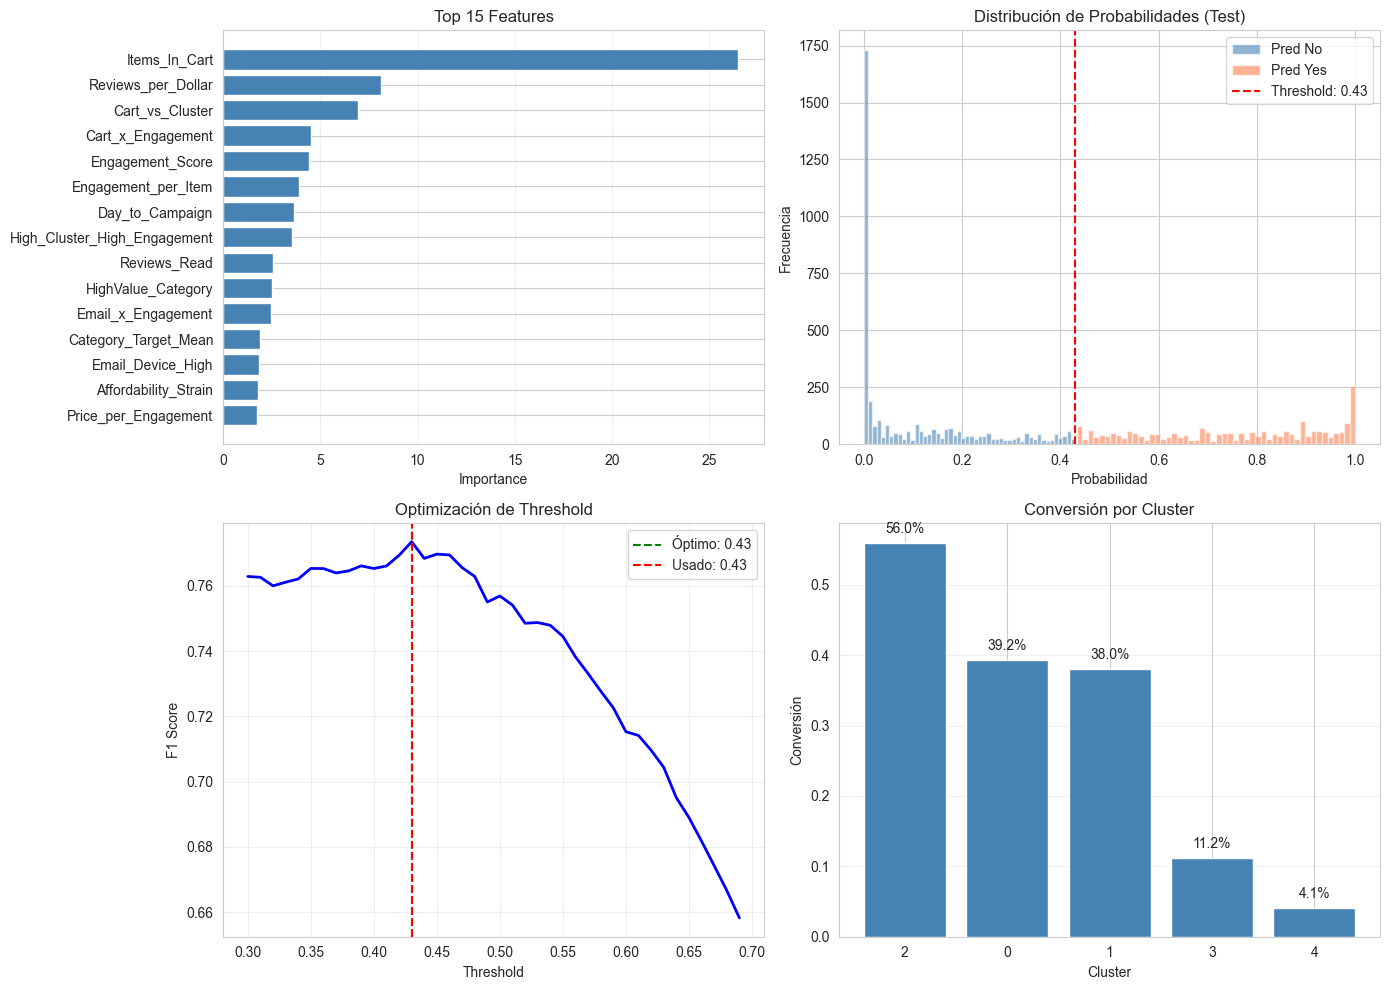

In [95]:
# ============================================================================
# PIPELINE FINAL: CATBOOST SOLO (OPTIMIZADO)
# Lo mejor de las mejoras anteriores + simplicidad
# ============================================================================
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import lightgbm as lgb

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    raise ImportError("❌ CatBoost no instalado. Instalar con: pip install catboost")

print("🐱 PIPELINE FINAL: CATBOOST SOLO OPTIMIZADO")
print("=" * 70)
print("Estrategia: Simplicidad + Máximo Performance")
print("=" * 70)

# ============================================================================
# 1. FEATURE ENGINEERING
# ============================================================================
print("\n🧪 Feature Engineering...")

# Target
if 'Purchase_Binary' not in train_featured.columns:
    train_featured['Purchase_Binary'] = train_featured['Purchase'].astype(int)
    val_featured['Purchase_Binary'] = val_featured['Purchase'].astype(int)
    test_featured['Purchase_Binary'] = test_featured['Purchase'].fillna(0).astype(int)

# Target Encoding (crítico para CatBoost)
cat_means = train_featured.groupby('Category')['Purchase_Binary'].mean()
global_mean = train_featured['Purchase_Binary'].mean()

def target_encode(df, col, mapping, global_mean):
    if col in df.columns:
        df[f'{col}_Target_Mean'] = df[col].map(mapping).fillna(global_mean)
    return df

train_featured = target_encode(train_featured, 'Category', cat_means, global_mean)
val_featured = target_encode(val_featured, 'Category', cat_means, global_mean)
test_featured = target_encode(test_featured, 'Category', cat_means, global_mean)

# Feature Selection
exclude_cols = ['id', 'Purchase', 'Purchase_Binary', 'Purchase_Num', 'Session_ID', 'set_origin', 'Cluster']
numeric_cols = train_featured.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

val_cols = val_featured.columns.tolist()
test_cols = test_featured.columns.tolist()
feature_cols = [c for c in feature_cols if c in val_cols and c in test_cols]

# ============================================================================
# 2. FEATURE SELECTION CON PROTECCIÓN
# ============================================================================
print("\n✂️  Feature Selection...")

# Features críticas que no se pueden eliminar
force_keep = [
    'Low_Conv_Cluster', 
    'High_Conv_Cluster', 
    'Purchase_Binary_cluster_mean', 
    'Category_Target_Mean'
]
force_keep = [f for f in force_keep if f in feature_cols]
print(f"🛡️  Features protegidas: {len(force_keep)}")

# Selector rápido con LightGBM
lgb_selector = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
X_sel = train_featured[feature_cols].fillna(0)
y_sel = train_featured['Purchase_Binary']
lgb_selector.fit(X_sel, y_sel)

# Top features + protegidas
imp_df = pd.DataFrame({
    'feature': feature_cols, 
    'importance': lgb_selector.feature_importances_
}).sort_values('importance', ascending=False)

top_features = imp_df.head(35)['feature'].tolist()
final_features = list(set(top_features + force_keep))

print(f"📉 {len(feature_cols)} → {len(final_features)} features")

# ============================================================================
# 3. PREPARAR DATOS PARA CATBOOST
# ============================================================================
print("\n🐱 Preparando datos para CatBoost...")

# CatBoost maneja categóricas nativamente
cat_cols = ['Device_Type', 'Time_of_Day', 'Payment_Method', 'Referral_Source', 'AB_Bucket', 'Category']
cat_features = [c for c in cat_cols if c in final_features]

print(f"📊 Total features: {len(final_features)}")
print(f"📂 Categóricas nativas: {len(cat_features)}")

# Preparar datasets
X_train = train_featured[final_features].copy()
X_val = val_featured[final_features].copy()
X_test = test_featured[final_features].copy()

y_train = train_featured['Purchase_Binary']
y_val = val_featured['Purchase_Binary']

# Convertir categóricas a string (requerido por CatBoost)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Obtener índices de categóricas
cat_indices = [X_train.columns.get_loc(c) for c in cat_features]

print(f"✅ Train: {X_train.shape}")
print(f"✅ Val: {X_val.shape}")
print(f"✅ Test: {X_test.shape}")

# ============================================================================
# 4. ENTRENAR CATBOOST CON TIMESERIESPLIT
# ============================================================================
print("\n🚀 Entrenando CatBoost (TimeSeriesSplit + RandomSearch)...")
print("-" * 70)

# TimeSeriesSplit para validación temporal
tscv = TimeSeriesSplit(n_splits=3)
print(f"✅ TimeSeriesSplit con {tscv.n_splits} splits")

# Ratio para manejar desbalance
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"📊 Scale pos weight: {ratio:.2f}")

# CatBoost base
cb_clf = cb.CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    task_type='CPU',
    verbose=False,
    random_seed=42,
    cat_features=cat_indices,
    allow_writing_files=False
)

# Grid de hiperparámetros optimizado
param_dist = {
    'iterations': randint(500, 900),
    'depth': [5, 6, 7],
    'learning_rate': uniform(0.02, 0.06),
    'l2_leaf_reg': [3, 5, 7],
    'scale_pos_weight': [ratio * 0.8, ratio, ratio * 1.2]
}

# Random Search
search = RandomizedSearchCV(
    cb_clf,
    param_dist,
    n_iter=12,  # Más iteraciones para mejor resultado
    scoring='f1',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_cb = search.best_estimator_

print(f"\n🏆 Mejor F1 (CV): {search.best_score_:.4f}")
print(f"📊 Mejores parámetros:")
for param, value in search.best_params_.items():
    print(f"   {param}: {value}")

# ============================================================================
# 5. CALIBRACIÓN DE PROBABILIDADES
# ============================================================================
print("\n🎯 Calibrando probabilidades...")

cb_calibrated = CalibratedClassifierCV(best_cb, method='isotonic', cv=3)
cb_calibrated.fit(X_train, y_train)

print("✅ Modelo calibrado")

# Obtener probabilidades calibradas
p_val = cb_calibrated.predict_proba(X_val)[:, 1]
p_test = cb_calibrated.predict_proba(X_test)[:, 1]

# ============================================================================
# 6. OPTIMIZAR THRESHOLD
# ============================================================================
print("\n🎯 Optimizando threshold...")

best_f1 = 0
best_thresh = 0.5

for t in np.arange(0.30, 0.70, 0.01):
    y_pred_val = (p_val >= t).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Threshold óptimo: {best_thresh:.2f}")
print(f"✅ F1 Score (Val): {best_f1:.4f}")

# Calcular AUC
auc = roc_auc_score(y_val, p_val)
print(f"✅ AUC (Val): {auc:.4f}")

# ============================================================================
# 7. CLUSTER VETO GRADUAL
# ============================================================================
print("\n🛡️  Aplicando Cluster Veto Gradual...")
print("-" * 70)

# Calcular conversión por cluster
cluster_conv = train_featured.groupby('Cluster')['Purchase_Binary'].mean().to_dict()

print("Conversión por cluster:")
for cluster_id in sorted(cluster_conv.keys()):
    conv_rate = cluster_conv[cluster_id]
    print(f"  Cluster {cluster_id}: {conv_rate:.2%}")

# Aplicar penalizaciones graduales
p_test_vetoed = p_test.copy()
veto_stats = {'extreme_70': 0, 'high_50': 0, 'medium_25': 0}

if 'Cluster' in test_featured.columns:
    for cluster_id, conv_rate in cluster_conv.items():
        mask = (test_featured['Cluster'] == cluster_id)
        n_affected = mask.sum()
        
        if conv_rate < 0.08:
            # Conversión extremadamente baja
            p_test_vetoed[mask] *= 0.30
            veto_stats['extreme_70'] += n_affected
            print(f"  ⛔ Cluster {cluster_id} ({conv_rate:.1%}): {n_affected} casos → -70%")
        elif conv_rate < 0.15:
            # Conversión baja
            p_test_vetoed[mask] *= 0.50
            veto_stats['high_50'] += n_affected
            print(f"  ⚠️  Cluster {cluster_id} ({conv_rate:.1%}): {n_affected} casos → -50%")
        elif conv_rate < 0.25:
            # Conversión media-baja
            p_test_vetoed[mask] *= 0.75
            veto_stats['medium_25'] += n_affected
            print(f"  ℹ️  Cluster {cluster_id} ({conv_rate:.1%}): {n_affected} casos → -25%")
    
    print(f"\n📊 Total penalizaciones:")
    print(f"   -70%: {veto_stats['extreme_70']} casos")
    print(f"   -50%: {veto_stats['high_50']} casos")
    print(f"   -25%: {veto_stats['medium_25']} casos")
    
    p_test = p_test_vetoed

# ============================================================================
# 8. GENERAR SUBMISSION
# ============================================================================
print("\n💾 Generando submission...")
print("=" * 70)

# Threshold de seguridad (nunca menos de 0.50 para evitar falsos positivos)
SAFE_THRESH = max(best_thresh, 0.35)
print(f"⚙️  Threshold final: {SAFE_THRESH:.3f}")

y_pred_test = (p_test >= SAFE_THRESH).astype(int)

# Crear submission
submission = pd.DataFrame({
    "id": test_featured["id"],
    "Purchase": y_pred_test
})

filename = "../data/submissions/catboost_solo_optimized.csv"
submission.to_csv(filename, index=False)

conv_pred = (submission['Purchase'] == 1).mean()
print(f"✅ Guardado: {filename}")
print(f"📊 Conversión predicha: {conv_pred:.2%}")

# ============================================================================
# 9. MÉTRICAS FINALES EN VALIDATION
# ============================================================================
print("\n📊 MÉTRICAS FINALES (Validation):")
print("=" * 70)

y_pred_val = (p_val >= SAFE_THRESH).astype(int)

print(classification_report(y_val, y_pred_val, target_names=['No', 'Yes']))

print(f"\n🎯 Resumen:")
print(f"   F1 Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"   AUC: {auc:.4f}")
print(f"   Accuracy: {(y_pred_val == y_val).mean():.4f}")

# ============================================================================
# 10. FEATURE IMPORTANCE
# ============================================================================
print("\n📊 TOP 15 FEATURES MÁS IMPORTANTES:")
print("-" * 70)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_cb.feature_importances_
}).sort_values('importance', ascending=False).head(15)

for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:<35} {row['importance']:>8.1f}")

# ============================================================================
# 11. VISUALIZACIONES
# ============================================================================
print("\n📊 Generando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature Importance
ax1 = axes[0, 0]
top_15 = feature_importance.head(15)
ax1.barh(range(len(top_15)), top_15['importance'].values, color='steelblue')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title('Top 15 Features')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Distribución de probabilidades
ax2 = axes[0, 1]
ax2.hist(p_test[y_pred_test == 0], bins=50, alpha=0.6, label='Pred No', color='steelblue')
ax2.hist(p_test[y_pred_test == 1], bins=50, alpha=0.6, label='Pred Yes', color='coral')
ax2.axvline(SAFE_THRESH, color='red', linestyle='--', label=f'Threshold: {SAFE_THRESH:.2f}')
ax2.set_xlabel('Probabilidad')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Probabilidades (Test)')
ax2.legend()

# 3. Threshold optimization curve
ax3 = axes[1, 0]
thresholds = np.arange(0.30, 0.70, 0.01)
f1_scores = []
for t in thresholds:
    f1 = f1_score(y_val, (p_val >= t).astype(int))
    f1_scores.append(f1)
ax3.plot(thresholds, f1_scores, 'b-', linewidth=2)
ax3.axvline(best_thresh, color='green', linestyle='--', label=f'Óptimo: {best_thresh:.2f}')
ax3.axvline(SAFE_THRESH, color='red', linestyle='--', label=f'Usado: {SAFE_THRESH:.2f}')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('F1 Score')
ax3.set_title('Optimización de Threshold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Conversión por cluster
ax4 = axes[1, 1]
cluster_df = pd.DataFrame(list(cluster_conv.items()), columns=['Cluster', 'Conv'])
cluster_df = cluster_df.sort_values('Conv', ascending=False)
bars = ax4.bar(cluster_df['Cluster'].astype(str), cluster_df['Conv'], color='steelblue')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Conversión')
ax4.set_title('Conversión por Cluster')
ax4.grid(axis='y', alpha=0.3)
for bar, conv in zip(bars, cluster_df['Conv']):
    ax4.text(bar.get_x() + bar.get_width()/2, conv + 0.01, 
             f'{conv:.1%}', ha='center', va='bottom')

plt.tight_layout()
#plt.savefig('../reports/figures/catboost_solo_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Visualizaciones guardadas")

print("\n" + "=" * 70)
print("✨ PIPELINE COMPLETADO")
print("=" * 70)
print(f"🎯 F1 Final: {f1_score(y_val, y_pred_val):.4f}")
print(f"📊 Conversión: {conv_pred:.2%}")
print(f"🏆 Modelo: CatBoost Solo Optimizado")

In [20]:
# Définir les features catégorielles
cat_features = [
    "Device_Type",
    "Time_of_Day",
    "Payment_Method",
    "Referral_Source",
    "Category",
]

print("=" * 60)
print("RARE CATEGORIES HANDLING")
print("=" * 60)

train_featured, val_featured, test_featured, known_cats = handle_rare_categories(
    train_featured,
    val_featured,
    test_featured,
    cat_features=cat_features,
    threshold=0.01,
)

# Afficher les catégories gardées
print("\n📋 Catégories valides par feature:")
for col, cats in known_cats.items():
    print(f"  {col}: {cats}")

RARE CATEGORIES HANDLING
📊 Groupement des catégories rares (<1.0%):
  - Payment_Method: 1/5 catégories → 'Other'
  - Referral_Source: 1/6 catégories → 'Other'

✓ Groupement terminé

📋 Catégories valides par feature:
  Device_Type: ['Mobile', 'Desktop', 'Tablet', 'Unknown']
  Time_of_Day: ['evening', 'afternoon', 'morning', 'Unknown']
  Payment_Method: ['PayPal', 'Cash', 'Bank', 'Credit']
  Referral_Source: ['Search_engine', 'Direct', 'Email', 'Social_media', 'Ads']
  Category: [2.0, 1.0, 4.0, 0.0, 3.0]


In [21]:
def prepare_classic_data(
    train,
    val,
    test,
    cat_features,
    scale=True,
    target_col="Purchase",
    id_col="id",
    session_col="Session_ID",
):
    """
    Prépare les données pour modèles classiques (one-hot + scaling)

    Returns:
    --------
    X_train, y_train, X_val, y_val, X_test, scaler
    """

    train = train.copy()
    val = val.copy()
    test = test.copy() if test is not None and len(test) > 0 else None

    # Colonnes à drop
    drop_cols = [target_col, id_col, session_col]
    drop_cols = [c for c in drop_cols if c in train.columns]

    # Séparer features et target
    X_train = train.drop(columns=drop_cols)
    y_train = train[target_col]

    X_val = val.drop(columns=drop_cols)
    y_val = val[target_col] if target_col in val.columns else None

    if test is not None:
        X_test = (
            test.drop(columns=drop_cols)
            if target_col in test.columns
            else test.drop(
                columns=[c for c in [id_col, session_col] if c in test.columns]
            )
        )
    else:
        X_test = None

    print("🔄 One-hot encoding...")

    # One-hot encoding
    X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val, columns=cat_features, drop_first=True)
    if X_test is not None:
        X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True)
    else:
        X_test_encoded = None

    # Aligner les colonnes (val/test doivent avoir les mêmes que train)
    train_cols = X_train_encoded.columns.tolist()

    # Ajouter les colonnes manquantes dans val
    missing_in_val = set(train_cols) - set(X_val_encoded.columns)
    for col in missing_in_val:
        X_val_encoded[col] = 0

    # Supprimer les colonnes en trop dans val
    extra_in_val = set(X_val_encoded.columns) - set(train_cols)
    X_val_encoded = X_val_encoded.drop(columns=list(extra_in_val))

    # Réordonner les colonnes
    X_val_encoded = X_val_encoded[train_cols]

    # Même chose pour test
    if X_test_encoded is not None:
        missing_in_test = set(train_cols) - set(X_test_encoded.columns)
        for col in missing_in_test:
            X_test_encoded[col] = 0

        extra_in_test = set(X_test_encoded.columns) - set(train_cols)
        X_test_encoded = X_test_encoded.drop(columns=list(extra_in_test))

        X_test_encoded = X_test_encoded[train_cols]

    print(f"  ✓ Train: {X_train_encoded.shape[1]} features après encoding")
    print(
        f"  ✓ Val:   {len(missing_in_val)} colonnes ajoutées, {len(extra_in_val)} supprimées"
    )
    if X_test_encoded is not None:
        print(
            f"  ✓ Test:  {len(missing_in_test)} colonnes ajoutées, {len(extra_in_test)} supprimées"
        )

    # Scaling
    scaler = None
    if scale:
        print("\n📏 Scaling (StandardScaler)...")
        scaler = StandardScaler()

        # Fit sur train uniquement
        X_train_encoded = pd.DataFrame(
            scaler.fit_transform(X_train_encoded),
            columns=X_train_encoded.columns,
            index=X_train_encoded.index,
        )

        # Transform sur val et test
        X_val_encoded = pd.DataFrame(
            scaler.transform(X_val_encoded),
            columns=X_val_encoded.columns,
            index=X_val_encoded.index,
        )

        if X_test_encoded is not None:
            X_test_encoded = pd.DataFrame(
                scaler.transform(X_test_encoded),
                columns=X_test_encoded.columns,
                index=X_test_encoded.index,
            )

        print("  ✓ Scaling terminé")

    print("\n📦 Classic ML Data Ready:")
    print(f"  X_train: {X_train_encoded.shape}")
    print(f"  X_val:   {X_val_encoded.shape}")
    if X_test_encoded is not None:
        print(f"  X_test:  {X_test_encoded.shape}")

    return X_train_encoded, y_train, X_val_encoded, y_val, X_test_encoded, scaler


print("=" * 60)
print("PIPELINE 2 : CLASSIC ML (ONE-HOT + SCALING)")
print("=" * 60)

X_train_cls, y_train_cls, X_val_cls, y_val_cls, X_test_cls, scaler = (
    prepare_classic_data(
        train_featured,
        val_featured,
        test_featured,
        cat_features=cat_features,
        scale=True,
    )
)

# Afficher les premières lignes
print("\n📊 Aperçu X_train_cls:")
display(X_train_cls.head())

# Vérifier la distribution (devrait être ~N(0,1) après scaling)
print("\n📊 Statistiques après scaling:")
display(X_train_cls.describe().loc[["mean", "std"]].T.head(10))


# Test rapide Logistic Regression sur le pipeline classic

print("=" * 60)
print("VALIDATION RAPIDE - LOGISTIC REGRESSION")
print("=" * 60)

PIPELINE 2 : CLASSIC ML (ONE-HOT + SCALING)
🔄 One-hot encoding...
  ✓ Train: 61 features après encoding
  ✓ Val:   0 colonnes ajoutées, 0 supprimées
  ✓ Test:  0 colonnes ajoutées, 0 supprimées

📏 Scaling (StandardScaler)...
  ✓ Scaling terminé

📦 Classic ML Data Ready:
  X_train: (11521, 61)
  X_val:   (1934, 61)
  X_test:  (6265, 61)

📊 Aperçu X_train_cls:


,Age,Gender,Reviews_Read,Price,Discount,Items_In_Cart,Email_Interaction,Socioeconomic_Status_Score,Engagement_Score,AB_Bucket,Price_Sine,Day,Campaign_Period,Effective_Discount,Net_Price,Price_Bucket,Email_x_Engagement,Cart_x_Engagement,Tablet_During_Campaign,Desktop_During_Campaign,Day_to_Campaign,HighValue_Category,Email_Device_High,Age_missing,Gender_missing,Reviews_Read_missing,Price_missing,Discount_missing,Category_missing,Items_In_Cart_missing,Time_of_Day_missing,Email_Interaction_missing,Device_Type_missing,Socioeconomic_Status_Score_missing,Engagement_Score_missing,AB_Bucket_missing,Price_Sine_missing,Effective_Discount_missing,Net_Price_missing,Price_Bucket_missing,Email_x_Engagement_missing,Cart_x_Engagement_missing,Device_Type_Mobile,Device_Type_Tablet,Device_Type_Unknown,Time_of_Day_afternoon,Time_of_Day_evening,Time_of_Day_morning,Payment_Method_Cash,Payment_Method_Credit,Payment_Method_Other,Payment_Method_PayPal,Referral_Source_Direct,Referral_Source_Email,Referral_Source_Other,Referral_Source_Search_engine,Referral_Source_Social_media,Category_1.0,Category_2.0,Category_3.0,Category_4.0
0,-0.279481,1.037054,0.013176,0.046446,-0.211112,0.876698,-0.896560,0.623698,-0.284206,-0.004382,1.414854,1.651266,-0.867166,-0.030954,0.083703,0.000000,-0.671590,0.373076,-0.258187,-0.450958,0.412678,0.837719,-0.557399,2.367716,-0.138227,-0.148322,-0.220461,-0.144925,-0.146169,-0.144612,-0.14209,-0.140813,-0.14209,-0.143671,-0.14209,-0.14017,-0.14771,-0.265754,-0.265754,-0.220461,-0.199973,-0.204161,1.119695,-0.414039,-0.14209,1.540664,-0.799708,-0.644886,-0.580257,1.812317,-0.053596,-0.595362,-0.499023,-0.498345,-0.051942,-0.50661,2.011574,1.989322,-0.515929,-0.485143,-0.501464
1,-0.530703,1.037054,-1.163533,-0.062935,-0.887311,-0.179097,1.115374,0.926499,-0.276065,1.005292,-0.199405,-0.077021,1.153182,-0.301175,0.061143,0.000000,0.594465,-0.240575,3.873163,-0.450958,-0.820397,0.837719,1.794046,-0.422348,-0.138227,-0.148322,-0.220461,-0.144925,-0.146169,-0.144612,-0.14209,-0.140813,-0.14209,-0.143671,-0.14209,-0.14017,-0.14771,-0.265754,-0.265754,-0.220461,-0.199973,-0.204161,-0.893100,2.415229,-0.14209,-0.649071,-0.799708,1.550661,1.723375,-0.551780,-0.053596,-0.595362,-0.499023,-0.498345,-0.051942,-0.50661,2.011574,-0.502684,-0.515929,-0.485143,-0.501464
2,-0.781924,-0.964270,0.013176,-0.455119,-1.563510,0.172835,1.115374,0.434447,-0.727760,-1.518893,-0.616947,-0.825946,-0.867166,-0.524020,-0.361446,-0.724021,0.157551,-0.319366,-0.258187,-0.450958,0.412678,0.837719,-0.557399,-0.422348,-0.138227,-0.148322,-0.220461,-0.144925,-0.146169,-0.144612,-0.14209,-0.140813,-0.14209,-0.143671,-0.14209,-0.14017,-0.14771,-0.265754,-0.265754,-0.220461,-0.199973,-0.204161,1.119695,-0.414039,-0.14209,-0.649071,1.250456,-0.644886,-0.580257,-0.551780,-0.053596,-0.595362,-0.499023,-0.498345,-0.051942,-0.50661,2.011574,1.989322,-0.515929,-0.485143,-0.501464
3,-0.614443,-0.964270,0.013176,-0.327362,-1.631129,-1.234892,1.115374,1.569951,-1.332941,-1.014056,-1.427259,1.305609,-0.867166,-0.528828,-0.188331,-0.724021,-0.427828,-0.861955,-0.258187,-0.450958,-0.409372,-1.193718,-0.557399,-0.422348,-0.138227,-0.148322,-0.220461,-0.144925,-0.146169,-0.144612,-0.14209,-0.140813,-0.14209,-0.143671,-0.14209,-0.14017,-0.14771,-0.265754,-0.265754,-0.220461,-0.199973,-0.204161,1.119695,-0.414039,-0.14209,-0.649071,1.250456,-0.644886,-0.580257,-0.551780,-0.053596,1.679651,-0.499023,-0.498345,-0.051942,-0.50661,2.011574,-0.502684,-0.515929,2.061249,-0.501464
4,0.306702,1.037054,-1.163533,-0.084613,-0.819691,-0.531029,-0.896560,0.935233,1.111501,-0.509219,0.981076,-1.171603,-0.867166,-0.289412,0.026755,0.000000,-0.671590,-0.008546,-0.258187,-0.450958,1.234727,0.837719,-0.557399,-0.422348,-0.138227,-0.148322,-0.220461,-0.144925,-0.146169,-0.144612,-0.14209,-0.140813,-0.14209,-0.143671,-0.14209,-0.14017,-0.14771,-0.265754,-0.265754,-0.220461,-0.199973,-0.204161,1.119695,-0.414039,-0.14209,-0.649071,1.250456,-0.644886,1.723375,-0.551780,-0.053596,-0.595362,-0.499023,


📊 Statistiques après scaling:


,mean,std
Age,-3.145359e-17,1.000043
Gender,5.874420e-17,1.000043
Reviews_Read,8.788503e-17,1.000043
Price,5.303938e-17,1.000043
Discount,3.453727e-17,1.000043
Items_In_Cart,-7.400844e-18,1.000043
Email_Interaction,-1.165633e-16,1.000043
Socioeconomic_Status_Score,4.718038e-17,1.000043
Engagement_Score,5.303938e-17,1.000043
AB_Bucket,-4.933896e-18,1.000043


VALIDATION RAPIDE - LOGISTIC REGRESSION


In [22]:
from sklearn.preprocessing import StandardScaler

# --- Assume df is the DataFrame after feature engineering and rare category handling ---

# 1. Select the Categorical Features for One-Hot Encoding (OHE)
ohe_cols = [
    "Device_Type",
    "Referral_Source",
    "Time_of_Day",
    "Payment_Method"
]

# 2. Apply One-Hot Encoding
# drop_first=True helps prevent multicollinearity, which is generally good practice
df_processed = pd.get_dummies(train_featured, columns=ohe_cols, drop_first=True)

# 3. Select Features for Segmentation (X)
# We choose a mix of demographic, behavioral, and engineered features.

# Base features (numerical/binary)
numerical_features = [
    "Age",
    "Reviews_Read",
    "Socioeconomic_Status_Score",
    "Engagement_Score",
    "Items_In_Cart",
    "Category", # Using the raw category ID might be useful, or we rely on HighValue_Category
    "Price_Sine", # Keep the cyclical price feature
    # 'Discount', # Removed to use the effective price features
    # 'Price',    # Removed to use the effective price features
    "Gender",
    "AB_Bucket",
    "HighValue_Category", # Engineered
    "Tablet_During_Campaign", # Engineered
    "Desktop_During_Campaign", # Engineered
    "Email_Device_High" # Engineered
]

# Engineered Price/Value/Time features
engineered_features = [
    "Effective_Discount",
    "Net_Price",
    "Price_Bucket",
    "Email_x_Engagement",
    "Cart_x_Engagement",
    "Day_to_Campaign",
]

# Get the list of one-hot encoded columns (assuming the prefix structure: colname_value)
# We exclude the original OHE columns since they are now processed
ohe_features = [col for col in df_processed.columns if any(col.startswith(f"{prefix}_") for prefix in ohe_cols)]

# The final list of features for clustering
segmentation_features = numerical_features + engineered_features + ohe_features

# Filter the DataFrame to include only the segmentation features
X = df_processed[segmentation_features].copy()

# 4. Standard Scaling (Crucial for K-Means)
scaler = StandardScaler()

# Fit the scaler and transform the data
# X_scaled is the final matrix ready for clustering
X_scaled = scaler.fit_transform(X)

# Optional: Convert back to DataFrame to maintain column names for analysis later
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Shape of the final matrix X_scaled: {X_scaled.shape}")
print(f"Features used for segmentation ({len(segmentation_features)}):")
print(segmentation_features)

# --- End of Preparation Code ---

Shape of the final matrix X_scaled: (11521, 36)
Features used for segmentation (36):
['Age', 'Reviews_Read', 'Socioeconomic_Status_Score', 'Engagement_Score', 'Items_In_Cart', 'Category', 'Price_Sine', 'Gender', 'AB_Bucket', 'HighValue_Category', 'Tablet_During_Campaign', 'Desktop_During_Campaign', 'Email_Device_High', 'Effective_Discount', 'Net_Price', 'Price_Bucket', 'Email_x_Engagement', 'Cart_x_Engagement', 'Day_to_Campaign', 'Time_of_Day_missing', 'Device_Type_missing', 'Device_Type_Mobile', 'Device_Type_Tablet', 'Device_Type_Unknown', 'Referral_Source_Direct', 'Referral_Source_Email', 'Referral_Source_Other', 'Referral_Source_Search_engine', 'Referral_Source_Social_media', 'Time_of_Day_afternoon', 'Time_of_Day_evening', 'Time_of_Day_morning', 'Payment_Method_Cash', 'Payment_Method_Credit', 'Payment_Method_Other', 'Payment_Method_PayPal']



Running K-Means to find optimal k (Elbow Method)...


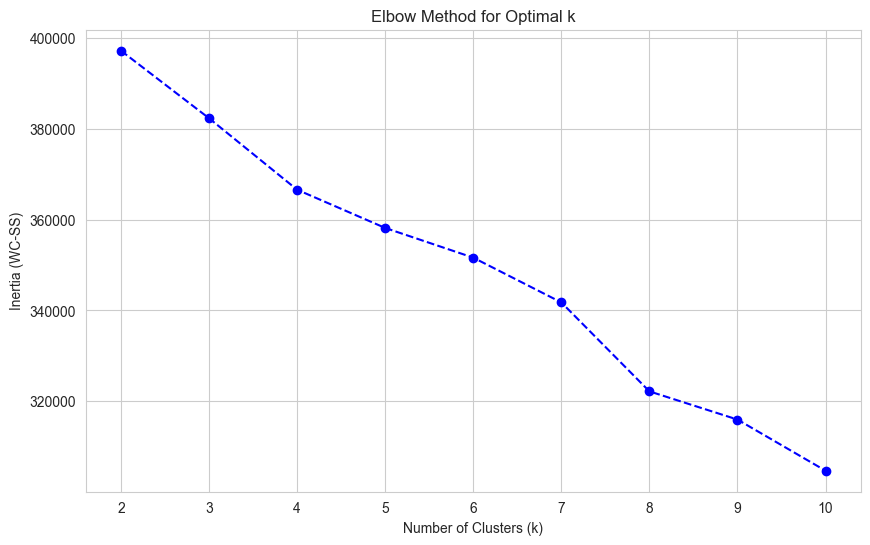


--- Plot Generated ---
Analyze the plot to find the 'elbow' point where the reduction in inertia slows significantly.


In [23]:
from sklearn.cluster import KMeans

# CODE TO DETERMINE OPTIMAL K (using X_scaled)
inertia = []
k_range = range(2, 11) # Testing k from 2 to 10

# Calculate inertia for each k
print("\nRunning K-Means to find optimal k (Elbow Method)...")
for k in k_range:
    # Set n_init='auto' for modern sklearn
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WC-SS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

print("\n--- Plot Generated ---")
print("Analyze the plot to find the 'elbow' point where the reduction in inertia slows significantly.")

In [24]:
# --- Setup: Redefine variables from previous steps to ensure consistency ---
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Use your training data as df
df1 = train_featured.copy() 

# Features used for clustering (re-run the selection to ensure X is correct)
ohe_cols = ["Device_Type", "Referral_Source", "Time_of_Day", "Payment_Method"]
numerical_features = ['Age', 'Reviews_Read', 'Socioeconomic_Status_Score', 'Engagement_Score', 'Items_In_Cart', 'Category', 'Price_Sine', 'Gender', 'AB_Bucket', 'HighValue_Category', 'Tablet_During_Campaign', 'Desktop_During_Campaign', 'Email_Device_High']
engineered_features = ['Effective_Discount', 'Net_Price', 'Price_Bucket', 'Email_x_Engagement', 'Cart_x_Engagement', 'Day_to_Campaign']

df_processed = pd.get_dummies(df1, columns=[col for col in ohe_cols if col in df1.columns], drop_first=True)
ohe_features = [col for col in df_processed.columns if any(col.startswith(f"{prefix}_") for prefix in ohe_cols)]
segmentation_features = numerical_features + engineered_features + ohe_features
segmentation_features = [col for col in segmentation_features if col in df_processed.columns] # Final available list

# CRUCIAL: Drop any NaN rows *only on the features chosen for clustering* to get X
# This creates the 11,521 row subset (X)
X = df_processed[segmentation_features].dropna().copy() 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Rerun K-Means with k=4
k = 4
kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans_model.fit_predict(X_scaled)

# --- CORRECTED INDEX ALIGNMENT AND PROFILING ---

print(f"Length of df (original): {len(df1)}")
print(f"Length of X (clustered subset): {len(X)}") # Should be 11,521
print(f"Length of cluster_labels: {len(cluster_labels)}") # Should be 11,521

# 1. Assign labels directly to the X DataFrame (The 11,521 rows that were clustered)
X_clustered = X.copy()
X_clustered['Cluster'] = cluster_labels 

# 2. Join the cluster labels back to the full original DataFrame (df) based on the original index
# X_clustered preserves the index of the rows that were clustered, df preserves all rows.
df_final = df1.merge(
    X_clustered[['Cluster']], 
    left_index=True, 
    right_index=True, 
    how='left' 
)

# 3. Final preparation for profiling
df_profile = df_final.copy() 
df_profile['Purchase_Binary'] = df_profile['Purchase'].map({'Yes': 1, 'No': 0}) 

# Drop rows that were NOT clustered (Cluster is NaN)
df_profile = df_profile.dropna(subset=['Cluster']).copy()
df_profile['Cluster'] = df_profile['Cluster'].astype(int)

# --- Final Profiling (All columns should now be available) ---

profile_cols_num = ['Age', 'Reviews_Read', 'Net_Price', 'Effective_Discount', 'Engagement_Score', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Day_to_Campaign']
profile_cols_cat = ['Device_Type', 'Referral_Source', 'Time_of_Day', 'Payment_Method', 'Gender']

# Filter to ensure only existing columns are used (just in case)
existing_num_cols = [col for col in profile_cols_num if col in df_profile.columns]
existing_cat_cols = [col for col in profile_cols_cat if col in df_profile.columns]

# A. Numerical Profile (Mean)
numerical_profile = df_profile.groupby('Cluster')[existing_num_cols].mean()
print("\n" + "="*40)
print("--- Numerical Profile (Mean per Cluster) ---")
print(numerical_profile.T)

# B. Conversion Profile (Mean of Purchase)
conversion_profile = df_profile.groupby('Cluster')['Purchase_Binary'].agg(['count', 'mean']).rename(columns={'count': 'Session Count', 'mean': 'Avg. Conversion Rate'})
print("\n--- Conversion Profile ---")
print(conversion_profile.sort_values(by='Avg. Conversion Rate', ascending=False))
print("="*40)

# C. Categorical Profile (Mode / Most Frequent)
print("\n--- Categorical Profile (Mode per Cluster) ---")
for col in existing_cat_cols:
    mode_results = df_profile.groupby('Cluster')[col].agg(lambda x: x.mode().iloc[0] if not x.empty else 'N/A')
    print(f"- {col} Mode:\n{mode_results}")

Length of df (original): 11521
Length of X (clustered subset): 11521
Length of cluster_labels: 11521

--- Numerical Profile (Mean per Cluster) ---
Cluster                              0           1           2           3
Age                          30.975347   31.475827   31.182684   31.843783
Reviews_Read                  2.959938    2.954198    3.016165    2.943051
Net_Price                   423.004854  412.308850  416.972112  411.374086
Effective_Discount          147.248477  134.860103  137.166794  137.943884
Engagement_Score              2.273927    2.224702    2.292125    2.241019
Items_In_Cart                 3.463790    3.440840    3.509743    3.664577
Socioeconomic_Status_Score    5.092214    5.025576    5.102055    5.332764
Day_to_Campaign               0.000000    7.336832    7.594553    6.072623

--- Conversion Profile ---
         Session Count  Avg. Conversion Rate
Cluster                                     
0                    0                   NaN
1              

In [26]:
# --- Setup and Imports ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering


# Assuming df_featured is the DataFrame containing all engineered columns
df = train_featured.copy()

# --- 1. Filter Data (Outside Campaign) and Feature Preparation ---

# Filter for sessions OUTSIDE campaign (Campaign_Period == False)
df_outside_campaign = df[df['Campaign_Period'] == False].copy()

# Define the optimal (broad) feature set components
ohe_cols = ["Device_Type", "Referral_Source", "Payment_Method", "Time_of_Day"]
# Exclude identifiers and targets from the clustering features
exclude_cols = ['id', 'Session_ID', 'Day', 'Purchase', 'Campaign_Period', 'Gender']

# Apply One-Hot Encoding to the filtered subset
df_processed = pd.get_dummies(
    df_outside_campaign, 
    columns=[col for col in ohe_cols if col in df_outside_campaign.columns], 
    drop_first=True
)

# Select all relevant features
segmentation_features = [
    col for col in df_processed.columns 
    if col not in exclude_cols and df_processed[col].dtype != object
]

X = df_processed[segmentation_features].copy()

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Spectral Clustering (k=4) ---
n_clusters = 4
# Using affinity='nearest_neighbors' for performance on larger datasets
spectral_model = SpectralClustering(
    n_clusters=n_clusters,
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42,
    assign_labels='kmeans' # Use k-means to stabilize the final cluster assignment
)

# Predict cluster labels
cluster_labels = spectral_model.fit_predict(X_scaled)

# --- 3. Assign Labels and Profile ---

# Assign labels back to the filtered DataFrame
df_profile_spectral = df_outside_campaign.loc[X.index].copy()
df_profile_spectral['Cluster'] = cluster_labels

print(f"Spectral Clustering complete on {len(df_profile_spectral)} sessions.")

# The df_profile_spectral DataFrame now holds the final clustered data
# for the outside-campaign sessions.

Spectral Clustering complete on 6576 sessions.


In [31]:
df_profile_spectral.dtypes

id                                      int64
Age                                   float64
Gender                                float64
Reviews_Read                          float64
Price                                 float64
Discount                              float64
Category                              float64
Items_In_Cart                         float64
Time_of_Day                            object
Email_Interaction                     float64
Device_Type                            object
Payment_Method                         object
Referral_Source                        object
Socioeconomic_Status_Score            float64
Engagement_Score                      float64
AB_Bucket                             float64
Price_Sine                            float64
Session_ID                             object
Day                                   float64
Campaign_Period                          bool
Purchase                               object
Effective_Discount                

In [29]:
# --- Setup for Profiling ---
import pandas as pd

# Assuming df_profile_spectral is the DataFrame resulting from Spectral Clustering
# It must contain the 'Cluster' column and the original features.

# Define profiling column lists
profile_cols_num = ['Net_Price', 'Effective_Discount', 'Engagement_Score', 'Items_In_Cart', 
                    'Socioeconomic_Status_Score', 'Day_to_Campaign', 'Reviews_Read', 'Category']
profile_cols_cat = ['Device_Type', 'Referral_Source', 'Time_of_Day', 'Payment_Method', 'Gender']

# Ensure only existing columns are used
existing_num_cols = [col for col in profile_cols_num if col in df_profile_spectral.columns]
existing_cat_cols = [col for col in profile_cols_cat if col in df_profile_spectral.columns]

# The 'Purchase_Binary' column is assumed to be 0/1 purchase data.
# Note: This line assumes 'Purchase' is available and is a 0/1 binary column
# If 'Purchase' is not a column, you'll need to re-add it or adjust the code.
df_profile_spectral['Purchase_Binary'] = df_profile_spectral['Purchase'] 


# A. Numerical Profile (Mean)
print("\n" + "="*70)
print("--- Numerical Profile (Mean per Cluster) ---")
numerical_profile = df_profile_spectral.groupby('Cluster')[existing_num_cols].mean()
# **CORRECTED LINE:** Print DataFrame directly
print(numerical_profile.T) 


# B. Conversion Profile (Mean of Purchase)
print("\n--- Conversion Profile ---")
conversion_profile = df_profile_spectral.groupby('Cluster')['Purchase_Binary'].agg(['count', 'mean']).rename(
    columns={'count': 'Session Count', 'mean': 'Avg. Conversion Rate'}
)
# **CORRECTED LINE:** Print DataFrame directly
print(conversion_profile.sort_values(by='Avg. Conversion Rate', ascending=False))
print("="*70)


# C. Categorical Profile (Mode / Most Frequent)
print("\n--- Categorical Profile (Mode per Cluster) ---")
for col in existing_cat_cols:
    # Use lambda function to find the mode (most frequent value)
    mode_results = df_profile_spectral.groupby('Cluster')[col].agg(lambda x: x.mode().iloc[0] if not x.empty else 'N/A')
    # **CORRECTED LINE:** Print Series directly
    print(f"- {col} Mode:")
    print(mode_results)


--- Numerical Profile (Mean per Cluster) ---
Cluster                              0           1           2           3
Net_Price                   365.226256  398.909918  432.054091  298.143851
Effective_Discount          119.206957  130.537552  143.464109  102.020618
Engagement_Score              2.229771    2.086783    2.276782    2.226752
Items_In_Cart                 3.540000    3.210526    3.530364    4.411765
Socioeconomic_Status_Score    5.161169    6.009474    5.046603    4.478235
Day_to_Campaign              10.684375    6.947368   10.434818   12.470588
Reviews_Read                  2.954375    2.578947    3.004251    3.647059
Category                      1.974375    2.000000    1.988462    2.000000

--- Conversion Profile ---
         Session Count Avg. Conversion Rate
Cluster                                    
3                   17             0.352941
0                 1600             0.331875
2                 4940             0.327328
1                   19         